## ***CSE354 FINAL PROJECT***

This is the google colab notebook for the final project for CSE354 spring '23 semester. Group members are Ryan Engel, Ramy Abdullazziz, and Sahibjot Bhullar. Our project will calculate sentiment analysis of finanicial documents using the Financial Phrasebank dataset. We will be training 2 models, DistilBERT and ELECTRA, on this dataset and will analyze their performance on the given task.

We used this paper as a reference to learn more about the performance of language models in the finance domain. The link can be found here: https://cs.stanford.edu/~diyiy/docs/emnlp_flang_2022.pdf



Here we provide a link to the huggingface library containing the Financial Phrasebank dataset:    
   https://huggingface.co/datasets/financial_phrasebank

We used the huggingface library ELECTRA model documentation that can be found here:
https://huggingface.co/docs/transformers/model_doc/electra

We also used the huggingface library DistilBERT model documentation that can be found here:
https://huggingface.co/docs/transformers/model_doc/distilbert

## ***Imports***

Here we will begin installing and importing the tools necessary.

In [ ]:
!pip install transformers
!pip install datasets
!pip install -Uqq ipdb
!pip install beautifulsoup4
!pip install responses

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 40.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 60.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 11.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 60.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 35.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 15.3 MB/s eta 0:00:0

In [ ]:
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm
import numpy as np
from transformers import ElectraForSequenceClassification, ElectraTokenizer
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import AdamW
from datasets import load_dataset
import os
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt


torch.manual_seed(42)
np.random.seed(42)

Automatic pdb calling has been turned ON


## ***Load Dataset***

The dataset configuration we chose to use for training was the sentence_75agree configuration.

In [ ]:
dataset = load_dataset("financial_phrasebank",'sentences_75agree')

  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
BATCH_SIZE = 16
EPOCHS = 3
SAVE_PATH = 'models/electra-small-discriminator'

In [ ]:
# Load the datasets with different options
train_data = load_dataset('financial_phrasebank', 'sentences_75agree', split='train')
val_data = load_dataset('financial_phrasebank', 'sentences_66agree', split='train')
test_data = load_dataset('financial_phrasebank', 'sentences_allagree', split='train')

Generating train split:   0%|          | 0/3453 [00:00<?, ? examples/s]

Dataset financial_phrasebank downloaded and prepared to /root/.cache/huggingface/datasets/financial_phrasebank/sentences_75agree/1.0.0/550bde12e6c30e2674da973a55f57edde5181d53f5a5a34c1531c53f93b7e141. Subsequent calls will reuse this data.


Generating train split:   0%|          | 0/4217 [00:00<?, ? examples/s]

Dataset financial_phrasebank downloaded and prepared to /root/.cache/huggingface/datasets/financial_phrasebank/sentences_66agree/1.0.0/550bde12e6c30e2674da973a55f57edde5181d53f5a5a34c1531c53f93b7e141. Subsequent calls will reuse this data.


Generating train split:   0%|          | 0/2264 [00:00<?, ? examples/s]

Dataset financial_phrasebank downloaded and prepared to /root/.cache/huggingface/datasets/financial_phrasebank/sentences_allagree/1.0.0/550bde12e6c30e2674da973a55f57edde5181d53f5a5a34c1531c53f93b7e141. Subsequent calls will reuse this data.


## ***Initializing the model class***


Now we will write the code for the model class, this will set up the pre-trained financial phrasebank dataset, along with its tokenizer from the hugging face libary.

In [ ]:
class Model():

  def __init__(self, model_name ='google/electra-small-discriminator', num_classes=3):

    self.tokenizer = AutoTokenizer.from_pretrained(model_name)
    self.model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_classes)

  def get_tokenizer_and_model(self):
    return self.model, self.tokenizer

## ***Initialize data loader class***

Here we will read data, tokenize it using a tokenizer, and convert this data to tensors.

In [ ]:
class DatasetLoader(Dataset):

  def __init__(self, data, tokenizer):
    self.data = data
    self.tokenizer = tokenizer

  def tokenize_data(self):
    print("Processing data..")
    tokens = []
    labels = []
    label_dict = {'positive': 2, 'negative': 0, 'neutral':1}

    sentance_list = self.data['sentence']
    label_list = self.data['label']

    for (review, label) in tqdm(zip(sentance_list, label_list), total=len(sentance_list)):

      tokenized_review = self.tokenizer.encode_plus(text = review, 
                                                    add_special_tokens=True, 
                                                    max_length=512, 
                                                    truncation=True, 
                                                    padding = 'max_length',
                                                    return_tensors = 'pt')

      input_ids = tokenized_review['input_ids'].squeeze()

      labels.append(label)
      tokens.append(input_ids)

    tokens = torch.stack(tokens)
    labels = torch.tensor(labels)
    dataset = TensorDataset(tokens, labels)

    return dataset

  def get_data_loaders(self, batch_size=32, shuffle=True):
    processed_dataset = self.tokenize_data()

    data_loader = DataLoader(
        processed_dataset,
        shuffle=shuffle,
        batch_size=batch_size
    )

    return data_loader

## ***Training Function***

Now we will run the model class on the dataset class, we will do this in a new class called the trainer class.

In [ ]:
class Trainer():

  def __init__(self, options):
    self.device = options['device']
    self.train_data = options['train_data']
    self.val_data = options['val_data']
    self.batch_size = options['batch_size']
    self.epochs = options['epochs']
    self.save_path = options['save_path']
    self.training_type = options['training_type']
    transformer = Model()
    self.model, self.tokenizer = transformer.get_tokenizer_and_model()
    self.model.to(self.device)

  def get_performance_metrics(self, preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    precision = precision_score(labels_flat, pred_flat, average='weighted', zero_division=0)
    recall = recall_score(labels_flat, pred_flat, average='weighted', zero_division=0)
    f1 = f1_score(labels_flat, pred_flat, average='weighted', zero_division=0)
    return precision, recall, f1

  def set_training_parameters(self):

    trainable_layers = []
    if self.training_type in ['top_2_training', 'top_4_training', 'all_training']:
      if self.training_type != 'top_2_training':
        trainable_layers.extend(['transformer.layer.3', 'transformer.layer.2'])
      trainable_layers.extend(['tranformer.layer.5', 'transformer.layer.4'])
    trainable_layers.extend(['pre_classifier', 'classifier'])

    for name, layer in self.model.named_parameters():
      layer.requres_grad = any(trainable_layer in name for trainable_layer in trainable_layers)


  def train(self, data_loader, optimizer):
    self.model.train()
    total_recall = 0
    total_precision = 0
    total_f1 = 0
    total_loss = 0
    for batch_idx, (reviews, labels) in enumerate(tqdm(data_loader)):
      self.model.zero_grad()

      reviews = reviews.to(self.device)
      labels = labels.to(self.device)

      outputs = self.model(reviews, labels=labels)

      optimizer.zero_grad()
      outputs.loss.backward()
      optimizer.step()

      loss, logits = outputs[:2]
      total_loss += loss

      batch_precision, batch_recall, batch_f1 = self.get_performance_metrics(logits.detach().cpu().numpy(), labels.detach().cpu().numpy())
      total_precision += batch_precision
      total_recall += batch_recall
      total_f1 += batch_f1

    precision = total_precision/len(data_loader)
    recall = total_recall/len(data_loader)
    f1 = total_f1/len(data_loader)
    loss = total_loss/len(data_loader)

    return precision, recall, f1, loss

  def eval(self, data_loader):
    self.model.eval()
    total_recall = 0
    total_precision = 0
    total_f1 = 0
    total_loss = 0

    with torch.no_grad():
      for (reviews, labels) in tqdm(data_loader):

        reviews = reviews.to(self.device)
        labels = labels.to(self.device)

        outputs = self.model(reviews, labels=labels)

        loss, logits = outputs[:2]
        total_loss += loss

        precision, recall, f1 = self.get_performance_metrics(logits.detach().cpu().numpy(), labels.detach().cpu().numpy())
        total_precision += precision
        total_recall += recall
        total_f1 += f1

    precision = total_precision/len(data_loader)
    recall = total_recall/len(data_loader)
    f1 = total_f1/len(data_loader)
    loss = total_loss/len(data_loader)

    return precision, recall, f1, loss

  def save_transformer(self):
    self.model.save_pretrained(self.save_path)
    self.tokenizer.save_pretrained(self.save_path)

  def execute(self):
    last_best = 0
    train_dataset = DatasetLoader(self.train_data, self.tokenizer)
    train_data_loader = train_dataset.get_data_loaders(self.batch_size)
    val_dataset = DatasetLoader(self.val_data, self.tokenizer)
    val_data_loader = val_dataset.get_data_loaders(self.batch_size)
    optimizer = torch.optim.AdamW(self.model.parameters(), lr = 3e-5, eps = 1e-8)
    self.set_training_parameters()
    for epoch_i in range(0, self.epochs):
      train_precision, train_recall, train_f1, train_loss = self.train(train_data_loader, optimizer)
      print(f'Epoch {epoch_i + 1}: train_loss: {train_loss:.4f} train_precision: {train_precision:.4f} train_recall: {train_recall:.4f} train_f1: {train_f1:.4f}')
      val_precision, val_recall, val_f1, val_loss = self.eval(val_data_loader)
      print(f'Epoch {epoch_i + 1}: val_loss: {val_loss:.4f} val_precision: {val_precision:.4f} val_recall: {val_recall:.4f} val_f1: {val_f1:.4f}')

      if val_f1 > last_best:
        print("Saving model..")
        self.save_transformer()
        last_best = val_f1
        print("Model saved.")

 ## ***Experiments***
 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd "drive/MyDrive/"

/content/drive/MyDrive


Here we will be running different experiments on the data to try and optimize the performance of the model.

In [ ]:
options = {}
options['batch_size'] = BATCH_SIZE
options['device'] = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
options['train_data'] = train_data
options['val_data'] = val_data
options['save_path'] = SAVE_PATH + '_all_training'
options['epochs'] = EPOCHS
options['training_type'] = 'all_layers'
trainer = Trainer(options)
trainer.execute()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'classifi

Processing data..


100%|██████████| 3453/3453 [00:01<00:00, 2425.34it/s]


Processing data..


100%|██████████| 216/216 [02:43<00:00,  1.32it/s]


Epoch 1: train_loss: 0.8299 train_precision: 0.4825 train_recall: 0.6493 train_f1: 0.5405


100%|██████████| 264/264 [01:08<00:00,  3.86it/s]


Epoch 1: val_loss: 0.6202 val_precision: 0.6857 val_recall: 0.7220 val_f1: 0.6912
Saving model..
Model saved.


100%|██████████| 216/216 [02:44<00:00,  1.31it/s]


Epoch 2: train_loss: 0.3812 train_precision: 0.8750 train_recall: 0.8567 train_f1: 0.8515


100%|██████████| 264/264 [01:08<00:00,  3.83it/s]


Epoch 2: val_loss: 0.3205 val_precision: 0.9071 val_recall: 0.8926 val_f1: 0.8904
Saving model..
Model saved.


100%|██████████| 216/216 [02:45<00:00,  1.31it/s]


Epoch 3: train_loss: 0.1882 train_precision: 0.9482 train_recall: 0.9383 train_f1: 0.9371


100%|██████████| 264/264 [01:08<00:00,  3.84it/s]


Epoch 3: val_loss: 0.2911 val_precision: 0.9219 val_recall: 0.9049 val_f1: 0.9062
Saving model..
Model saved.


In [ ]:
options = {}
options['batch_size'] = BATCH_SIZE
options['device'] = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
options['train_data'] = train_data
options['val_data'] = val_data
options['save_path'] = SAVE_PATH + '_top_2_training'
options['epochs'] = EPOCHS
options['training_type'] = 'top_2_training'
trainer = Trainer(options)
trainer.execute()

Some weights of the model checkpoint at google/electra-large-generator were not used when initializing ElectraForSequenceClassification: ['generator_lm_head.weight', 'generator_predictions.LayerNorm.weight', 'generator_predictions.dense.bias', 'generator_lm_head.bias', 'generator_predictions.LayerNorm.bias', 'generator_predictions.dense.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-large-generator and are newly initializ

Processing data..


100%|██████████| 3453/3453 [00:01<00:00, 2008.58it/s]


> <ipython-input-70-aaec6eb74d57>(35)tokenize_data()
     34 
---> 35     return dataset
     36 

ipdb> c
> <ipython-input-70-aaec6eb74d57>(47)get_data_loaders()
     45     ipdb.set_trace()
     46 
---> 47     return data_loader

ipdb> c
Processing data..


100%|██████████| 4217/4217 [00:02<00:00, 1889.92it/s]


> <ipython-input-70-aaec6eb74d57>(35)tokenize_data()
     34 
---> 35     return dataset
     36 

ipdb> c
> <ipython-input-70-aaec6eb74d57>(47)get_data_loaders()
     45     ipdb.set_trace()
     46 
---> 47     return data_loader

ipdb> c


100%|██████████| 216/216 [02:00<00:00,  1.80it/s]


Epoch 1: train_loss: 0.9329 train_precision: 0.4009 train_recall: 0.6212 train_f1: 0.4833


100%|██████████| 264/264 [00:50<00:00,  5.21it/s]


Epoch 1: val_loss: 0.9193 val_precision: 0.3774 val_recall: 0.6011 val_f1: 0.4594
Saving model..
Model saved.


100%|██████████| 216/216 [02:05<00:00,  1.72it/s]


Epoch 2: train_loss: 0.8397 train_precision: 0.4681 train_recall: 0.6479 train_f1: 0.5329


100%|██████████| 264/264 [00:52<00:00,  5.05it/s]


Epoch 2: val_loss: 0.7358 val_precision: 0.5505 val_recall: 0.6644 val_f1: 0.5887
Saving model..
Model saved.


100%|██████████| 216/216 [02:07<00:00,  1.69it/s]


Epoch 3: train_loss: 0.5815 train_precision: 0.7546 train_recall: 0.7693 train_f1: 0.7407


100%|██████████| 264/264 [00:52<00:00,  5.06it/s]


Epoch 3: val_loss: 0.5438 val_precision: 0.8085 val_recall: 0.8056 val_f1: 0.7894
Saving model..
Model saved.


In [ ]:
options = {}
options['batch_size'] = BATCH_SIZE
options['device'] = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
options['train_data'] = train_data
options['val_data'] = val_data
options['save_path'] = SAVE_PATH + '_top_2_training'
options['epochs'] = EPOCHS
options['training_type'] = 'top_2_training'
trainer = Trainer(options)
trainer.execute()

Some weights of the model checkpoint at google/electra-small-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-discriminator and are newly initialized: ['classifier

Processing data..


100%|██████████| 3453/3453 [00:01<00:00, 1902.77it/s]


Processing data..


100%|██████████| 216/216 [01:01<00:00,  3.53it/s]


Epoch 1: train_loss: 0.8898 train_precision: 0.4524 train_recall: 0.6261 train_f1: 0.5087


100%|██████████| 264/264 [00:25<00:00, 10.35it/s]


Epoch 1: val_loss: 0.8369 val_precision: 0.5739 val_recall: 0.6553 val_f1: 0.5814
Saving model..
Model saved.


100%|██████████| 216/216 [01:00<00:00,  3.55it/s]


Epoch 2: train_loss: 0.6429 train_precision: 0.6803 train_recall: 0.7422 train_f1: 0.6955


100%|██████████| 264/264 [00:25<00:00, 10.31it/s]


Epoch 2: val_loss: 0.5599 val_precision: 0.8201 val_recall: 0.8154 val_f1: 0.7985
Saving model..
Model saved.


100%|██████████| 216/216 [01:00<00:00,  3.55it/s]


Epoch 3: train_loss: 0.3574 train_precision: 0.8945 train_recall: 0.8817 train_f1: 0.8764


100%|██████████| 264/264 [00:25<00:00, 10.30it/s]


Epoch 3: val_loss: 0.3964 val_precision: 0.9007 val_recall: 0.8642 val_f1: 0.8701
Saving model..
Model saved.


In [ ]:
options = {}
options['batch_size'] = BATCH_SIZE
options['device'] = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
options['train_data'] = train_data
options['val_data'] = val_data
options['save_path'] = SAVE_PATH + '_top_4_training'
options['epochs'] = EPOCHS
options['training_type'] = 'top_4_training'
trainer = Trainer(options)
trainer.execute()

Some weights of the model checkpoint at google/electra-large-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-large-discriminator and are newly initialized: ['classifier

Processing data..


100%|██████████| 3453/3453 [00:03<00:00, 1018.40it/s]


Processing data..


  0%|          | 0/216 [00:02<?, ?it/s]


OutOfMemoryError: ignored

> /usr/local/lib/python3.10/dist-packages/transformers/models/electra/modeling_electra.py(319)forward()
    317                 attention_scores = attention_scores + relative_position_scores_query + relative_position_scores_key
    318 
--> 319         attention_scores = attention_scores / math.sqrt(self.attention_head_size)
    320         if attention_mask is not None:
    321             # Apply the attention mask is (precomputed for all layers in ElectraModel forward() function)

ipdb> q



PYDEV DEBUGGER WARNING:
sys.settrace() should not be used when the debugger is being used.
This may cause the debugger to stop working correctly.
If this is needed, please check: 
http://pydev.blogspot.com/2007/06/why-cant-pydev-debugger-work-with.html
to see how to restore the debug tracing back correctly.
Call Location:
  File "/usr/lib/python3.10/bdb.py", line 361, in set_quit
    sys.settrace(None)



In [ ]:
options = {}
options['batch_size'] = BATCH_SIZE
options['device'] = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
options['train_data'] = train_data
options['val_data'] = val_data
options['save_path'] = SAVE_PATH + '_frozen_embeddings'
options['epochs'] = EPOCHS
options['training_type'] = 'frozen_embeddings'
trainer = Trainer(options)
trainer.execute()

Some weights of the model checkpoint at google/electra-small-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-discriminator and are newly initialized: ['classifier

Processing data..


100%|██████████| 3453/3453 [00:01<00:00, 1997.88it/s]


Processing data..


100%|██████████| 216/216 [01:00<00:00,  3.59it/s]


Epoch 1: train_loss: 0.8485 train_precision: 0.5151 train_recall: 0.6575 train_f1: 0.5589


100%|██████████| 264/264 [00:25<00:00, 10.27it/s]


Epoch 1: val_loss: 0.7211 val_precision: 0.6329 val_recall: 0.7094 val_f1: 0.6528
Saving model..
Model saved.


100%|██████████| 216/216 [01:00<00:00,  3.55it/s]


Epoch 2: train_loss: 0.5085 train_precision: 0.7676 train_recall: 0.8026 train_f1: 0.7727


100%|██████████| 264/264 [00:25<00:00, 10.28it/s]


Epoch 2: val_loss: 0.4718 val_precision: 0.8755 val_recall: 0.8418 val_f1: 0.8460
Saving model..
Model saved.


100%|██████████| 216/216 [01:01<00:00,  3.54it/s]


Epoch 3: train_loss: 0.3049 train_precision: 0.9268 train_recall: 0.9086 train_f1: 0.9086


100%|██████████| 264/264 [00:25<00:00, 10.28it/s]


Epoch 3: val_loss: 0.3356 val_precision: 0.9172 val_recall: 0.9025 val_f1: 0.9009
Saving model..
Model saved.


In [ ]:
options = {}
options['batch_size'] = BATCH_SIZE
options['device'] = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
options['train_data'] = train_data
options['val_data'] = val_data
options['save_path'] = SAVE_PATH + '_top_4_training'
options['epochs'] = EPOCHS
options['training_type'] = 'top_4_training'
trainer = Trainer(options)
trainer.execute()

Some weights of the model checkpoint at google/electra-small-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-discriminator and are newly initialized: ['classifier

Processing data..


100%|██████████| 3453/3453 [00:01<00:00, 1837.58it/s]


Processing data..


100%|██████████| 216/216 [01:01<00:00,  3.51it/s]


Epoch 1: train_loss: 0.8714 train_precision: 0.4796 train_recall: 0.6287 train_f1: 0.5255


100%|██████████| 264/264 [00:26<00:00,  9.83it/s]


Epoch 1: val_loss: 0.7770 val_precision: 0.5169 val_recall: 0.6352 val_f1: 0.5290
Saving model..
Model saved.


100%|██████████| 216/216 [01:02<00:00,  3.46it/s]


Epoch 2: train_loss: 0.5770 train_precision: 0.7152 train_recall: 0.7698 train_f1: 0.7286


100%|██████████| 264/264 [00:25<00:00, 10.38it/s]


Epoch 2: val_loss: 0.4911 val_precision: 0.8299 val_recall: 0.8305 val_f1: 0.8141
Saving model..
Model saved.


100%|██████████| 216/216 [01:00<00:00,  3.54it/s]


Epoch 3: train_loss: 0.3357 train_precision: 0.8989 train_recall: 0.8864 train_f1: 0.8815


100%|██████████| 264/264 [00:25<00:00, 10.34it/s]


Epoch 3: val_loss: 0.3189 val_precision: 0.9178 val_recall: 0.8984 val_f1: 0.8977
Saving model..
Model saved.


In [ ]:
options = {}
options['batch_size'] = BATCH_SIZE
options['device'] = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
options['train_data'] = train_data
options['val_data'] = val_data
options['save_path'] = SAVE_PATH + '_all_layers'
options['epochs'] = EPOCHS
options['training_type'] = 'all_training'
trainer = Trainer(options)
trainer.execute()

Some weights of the model checkpoint at google/electra-small-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-discriminator and are newly initialized: ['classifier

Processing data..


100%|██████████| 3453/3453 [00:01<00:00, 2062.07it/s]


Processing data..


100%|██████████| 216/216 [00:59<00:00,  3.62it/s]


Epoch 1: train_loss: 0.8843 train_precision: 0.4870 train_recall: 0.6325 train_f1: 0.5267


100%|██████████| 264/264 [00:25<00:00, 10.35it/s]


Epoch 1: val_loss: 0.8225 val_precision: 0.5807 val_recall: 0.6453 val_f1: 0.5703
Saving model..
Model saved.


100%|██████████| 216/216 [01:00<00:00,  3.56it/s]


Epoch 2: train_loss: 0.7623 train_precision: 0.6322 train_recall: 0.6869 train_f1: 0.6375


100%|██████████| 264/264 [00:25<00:00, 10.39it/s]


Epoch 2: val_loss: 0.7792 val_precision: 0.6151 val_recall: 0.6694 val_f1: 0.6296
Saving model..
Model saved.


100%|██████████| 216/216 [01:00<00:00,  3.56it/s]


Epoch 3: train_loss: 0.6354 train_precision: 0.6806 train_recall: 0.7384 train_f1: 0.6964


100%|██████████| 264/264 [00:25<00:00, 10.39it/s]


Epoch 3: val_loss: 0.6778 val_precision: 0.7394 val_recall: 0.7175 val_f1: 0.7105
Saving model..
Model saved.


#Testing analytics

In [ ]:
class Tester():

  def __init__(self, options):
    self.save_path = options['save_path']
    self.device = options['device']
    self.test_data = options['test_data']
    self.batch_size = options['batch_size']
    transformer = Model(self.save_path)
    self.model, self.tokenizer = transformer.get_tokenizer_and_model()
    self.model.to(self.device)

  def get_performance_metrics(self, preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    precision = precision_score(labels_flat, pred_flat, average='weighted',zero_division=0)
    recall = recall_score(labels_flat, pred_flat, average='weighted',zero_division=0)
    f1 = f1_score(labels_flat, pred_flat, average='weighted',zero_division=0)
    return precision, recall, f1

  def test(self, data_loader):
    self.model.eval()
    total_recall = 0
    total_precision = 0
    total_f1 = 0
    total_loss = 0
    precision_list, recall_list, f1_list, loss_list = [], [], [], []

    with torch.no_grad():
      for (reviews, labels) in tqdm(data_loader):

        reviews = reviews.to(self.device)
        labels = labels.to(self.device)
        reviews = reviews.squeeze()

        outputs = self.model(reviews, labels=labels)

        loss, logits = outputs[:2]
        total_loss += loss
        precision, recall, f1 = self.get_performance_metrics(logits.detach().cpu().numpy(), labels.detach().cpu().numpy())
        total_precision += precision
        precision_list.append(precision)
        recall_list.append(recall)
        total_recall += recall
        total_f1 += f1
        f1_list.append(f1)
        loss_list.append(loss.cpu().numpy())

    precision = total_precision/len(data_loader)
    recall = total_recall/len(data_loader)
    f1 = total_f1/len(data_loader)
    loss = total_loss/len(data_loader)

    return precision, recall, f1, loss, precision_list, recall_list, f1_list, loss_list
    
    precision = total_precision/len(data_loader)
    recall = total_recall/len(data_loader)
    f1 = total_f1/len(data_loader)
    loss = total_loss/len(data_loader)

    return precision, recall, f1, loss

  def plot_metrics(self, precision_list, recall_list, f1_list, loss_list):
    plt.figure(figsize=(10, 6))

    plt.plot(precision_list, label='Precision')
    plt.plot(recall_list, label='Recall')
    plt.plot(f1_list, label='F1 Score')
    plt.plot(loss_list, label='Loss')

    plt.xlabel('Batch')
    plt.ylabel('Value')
    plt.title('Test Metrics')
    plt.legend(loc='best')
    plt.show()

  def plot_final_results(self, results, labels):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    precisions = [result[0] for result in results]
    recalls = [result[1] for result in results]
    f1_scores = [result[2] for result in results]

    x = np.arange(len(labels))
    width = 0.35

    ax[0].bar(x, precisions, width, label='Precision')
    ax[1].bar(x, recalls, width, label='Recall')
    ax[2].bar(x, f1_scores, width, label='F1-score')

    for i, metric in enumerate(['Precision', 'Recall', 'F1-score']):
        ax[i].set_ylabel(metric)
        ax[i].set_xticks(x)
        ax[i].set_xticklabels(labels, rotation = 90)
        ax[i].legend(loc='best')
    
    fig.suptitle('Test Performance Metrics for Different Training Regimes')
    plt.gca().yaxis.grid(False)
    plt.tight_layout()
    plt.show()

  def generate_latex_table(self, results, labels):
    header = r'''
    \begin{tabular}{|l|c|c|c|}
    \hline
    \textbf{Model and Training Regime} & \textbf{Precision} & \textbf{Recall} & \textbf{F1 Score} \\ \hline
    '''
    rows = []
    for label, res in zip(labels, results):
        row = f"{label} & {res[0]:.4f} & {res[1]:.4f} & {res[2]:.4f} \\\\ \\hline"
        rows.append(row)

    footer = r'''\end{tabular}'''

    table = header + '\n' + '\n'.join(rows) + '\n' + footer
    return table

  def execute(self):
    test_dataset = DatasetLoader(self.test_data, self.tokenizer)
    test_data_loader = test_dataset.get_data_loaders(self.batch_size)

    test_precision, test_recall, test_f1, test_loss, precision_list, recall_list, f1_list, loss_list = self.test(test_data_loader)

    self.plot_metrics(precision_list, recall_list, f1_list, loss_list)

    print()
    print(f'test_loss: {test_loss:.4f} test_precision: {test_precision:.4f} test_recall: {test_recall:.4f} test_f1: {test_f1:.4f}')

    return test_precision, test_recall, test_f1



In [ ]:
results = []
labels = []

#Compare top 2 training between ELECTRA-large and DistilBERT

##DistilBERT

Processing data..


100%|██████████| 142/142 [00:38<00:00,  3.65it/s]


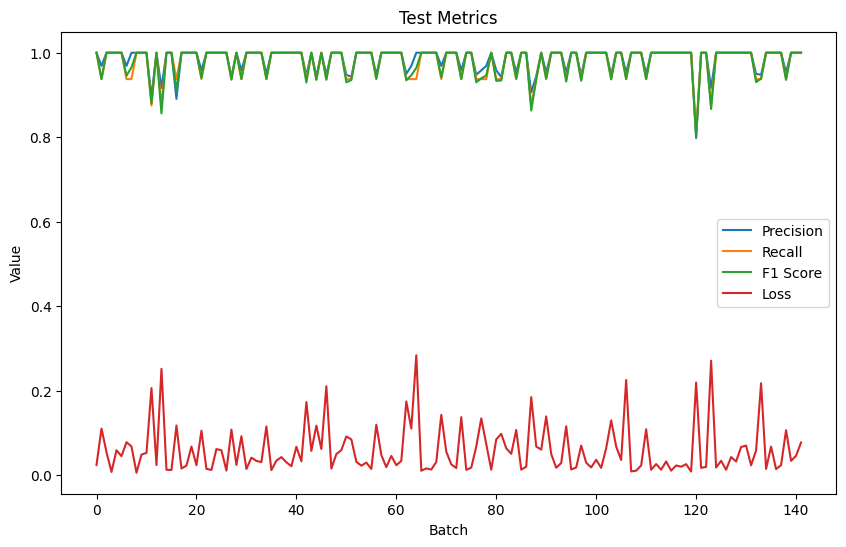


test_loss: 0.0599 test_precision: 0.9847 test_recall: 0.9798 test_f1: 0.9795


In [ ]:
options = {}
options['batch_size'] = BATCH_SIZE
options['device'] = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
options['test_data'] = test_data
options['save_path'] = 'models/DistilBERT_top_2_training'
tester = Tester(options)
D2_results = tester.execute()


##ELECTRA


Processing data..


100%|██████████| 142/142 [00:13<00:00, 10.33it/s]


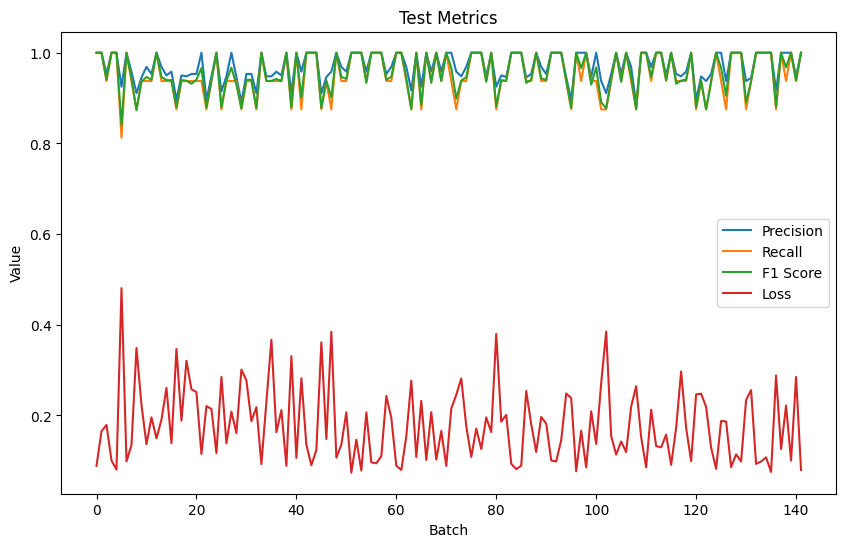


test_loss: 0.1780 test_precision: 0.9693 test_recall: 0.9520 test_f1: 0.9557


In [ ]:
options = {}
options['batch_size'] = BATCH_SIZE
options['device'] = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
options['test_data'] = test_data
options['save_path'] = 'models/electra-small-discriminator_top_2_training'
tester = Tester(options)
E2_results = tester.execute()


#Frozen Embeddings

##ELECTRA

Processing data..


100%|██████████| 142/142 [00:14<00:00, 10.02it/s]


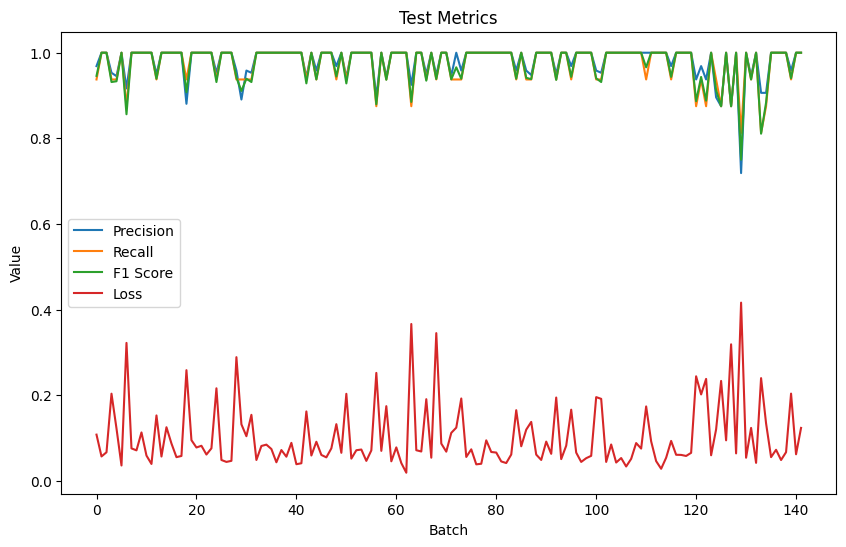


test_loss: 0.1025 test_precision: 0.9810 test_recall: 0.9758 test_f1: 0.9754


In [ ]:
options = {}
options['batch_size'] = BATCH_SIZE
options['device'] = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
options['test_data'] = test_data
options['save_path'] = 'models/electra-small-discriminator_frozen_embeddings'
tester = Tester(options)
Ef_results = tester.execute()


##DistilBERT


Processing data..


100%|██████████| 142/142 [00:38<00:00,  3.70it/s]


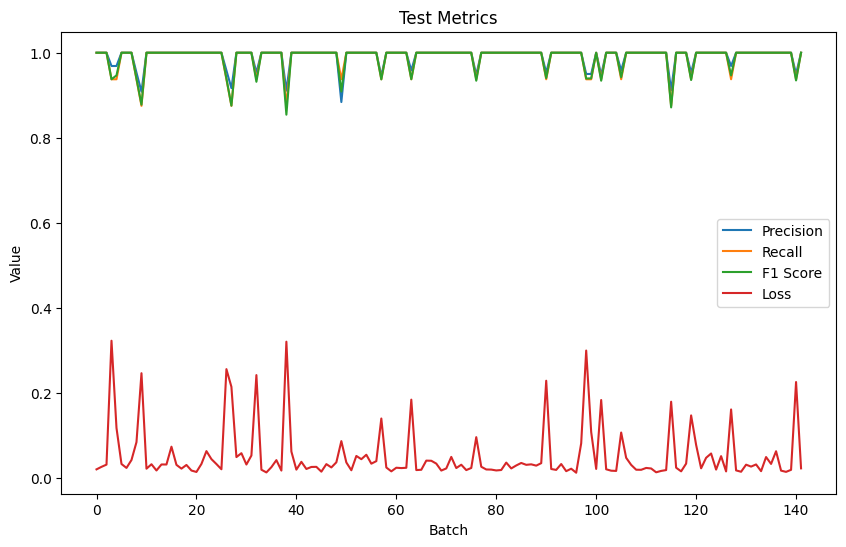


test_loss: 0.0523 test_precision: 0.9917 test_recall: 0.9890 test_f1: 0.9887


In [ ]:
options = {}
options['batch_size'] = BATCH_SIZE
options['device'] = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
options['test_data'] = test_data
options['save_path'] = 'models/distilBERT_frozen_embeddings'
tester = Tester(options)
df_results = tester.execute()


#All training

##ELECTRA


Processing data..


100%|██████████| 142/142 [00:13<00:00, 10.31it/s]


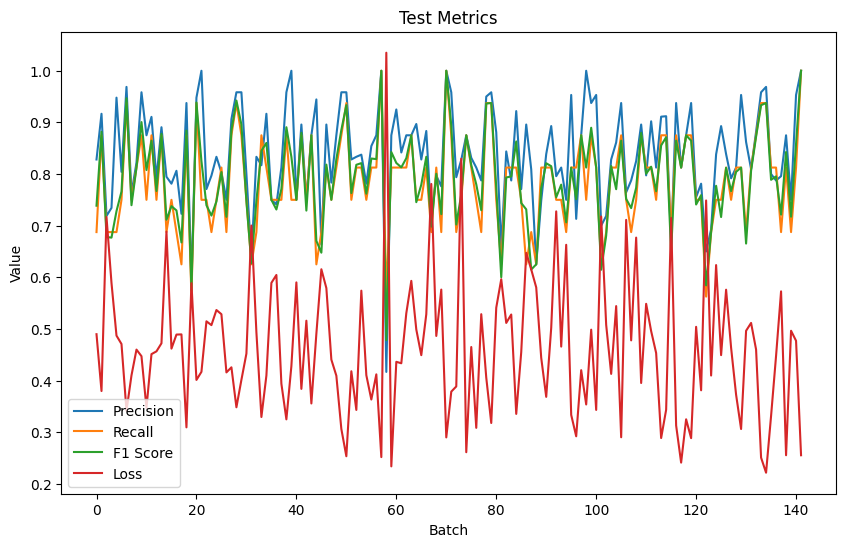


test_loss: 0.4634 test_precision: 0.8394 test_recall: 0.7843 test_f1: 0.7913


In [ ]:
options = {}
options['batch_size'] = BATCH_SIZE
options['device'] = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
options['test_data'] = test_data
options['save_path'] = 'models/electra-small-discriminator_all_layers'
tester = Tester(options)
EA_results = tester.execute()


Processing data..


100%|██████████| 142/142 [00:38<00:00,  3.67it/s]


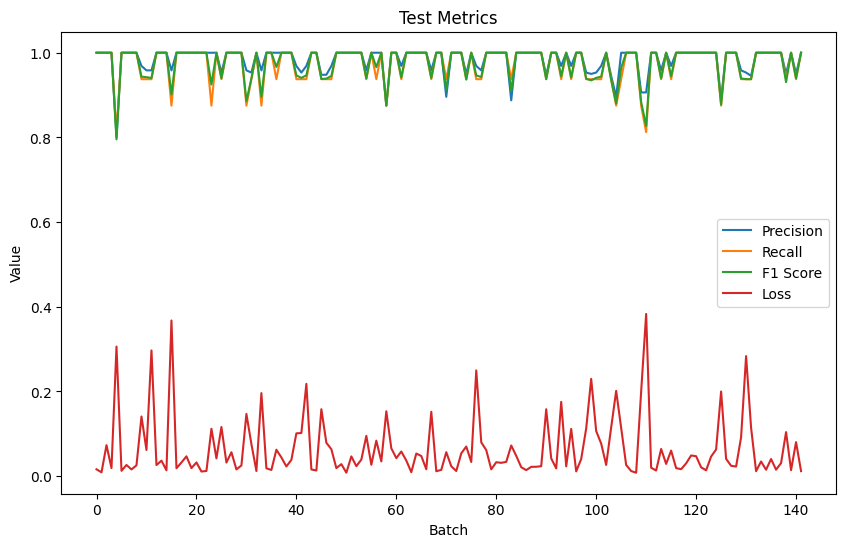


test_loss: 0.0653 test_precision: 0.9830 test_recall: 0.9740 test_f1: 0.9758


In [ ]:
options = {}
options['batch_size'] = BATCH_SIZE
options['device'] = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
options['test_data'] = test_data
options['save_path'] = 'models/distilBERT_all_training'
tester = Tester(options)
DA_results = tester.execute()


#Top 4

##ELECTRA

Processing data..


100%|██████████| 142/142 [00:13<00:00, 10.28it/s]


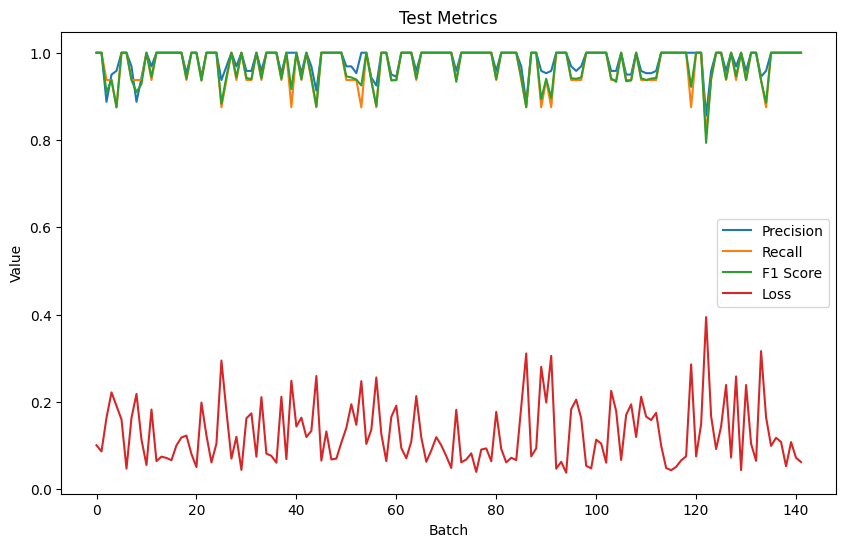


test_loss: 0.1293 test_precision: 0.9816 test_recall: 0.9701 test_f1: 0.9716


In [ ]:
options = {}
options['batch_size'] = BATCH_SIZE
options['device'] = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
options['test_data'] = test_data
options['save_path'] = 'models/electra-small-discriminator_top_4_training'
tester = Tester(options)
E4_results = tester.execute()


Processing data..


100%|██████████| 142/142 [00:38<00:00,  3.65it/s]


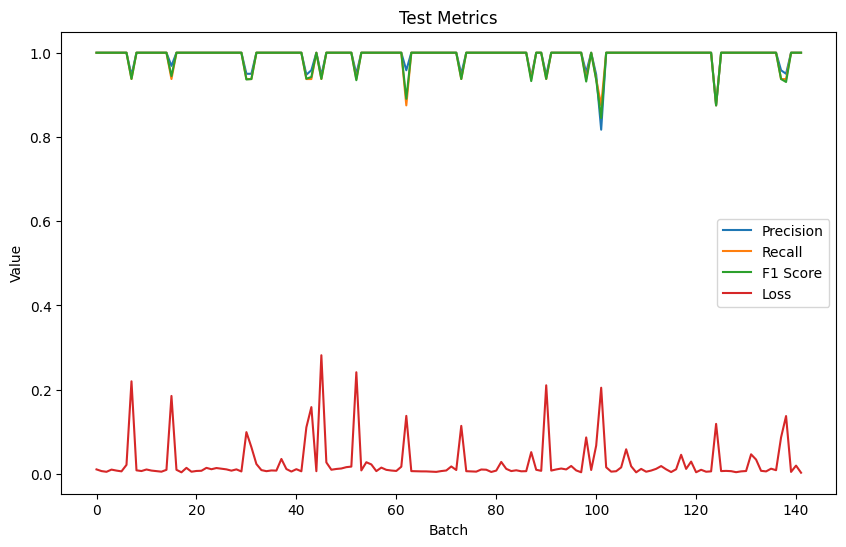


test_loss: 0.0282 test_precision: 0.9924 test_recall: 0.9908 test_f1: 0.9906


In [ ]:
options = {}
options['batch_size'] = BATCH_SIZE
options['device'] = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
options['test_data'] = test_data
options['save_path'] = 'models/DistilBERT_top_4_training'
tester = Tester(options)
D4_results = tester.execute()


#Plot comparison between all models and training regiments


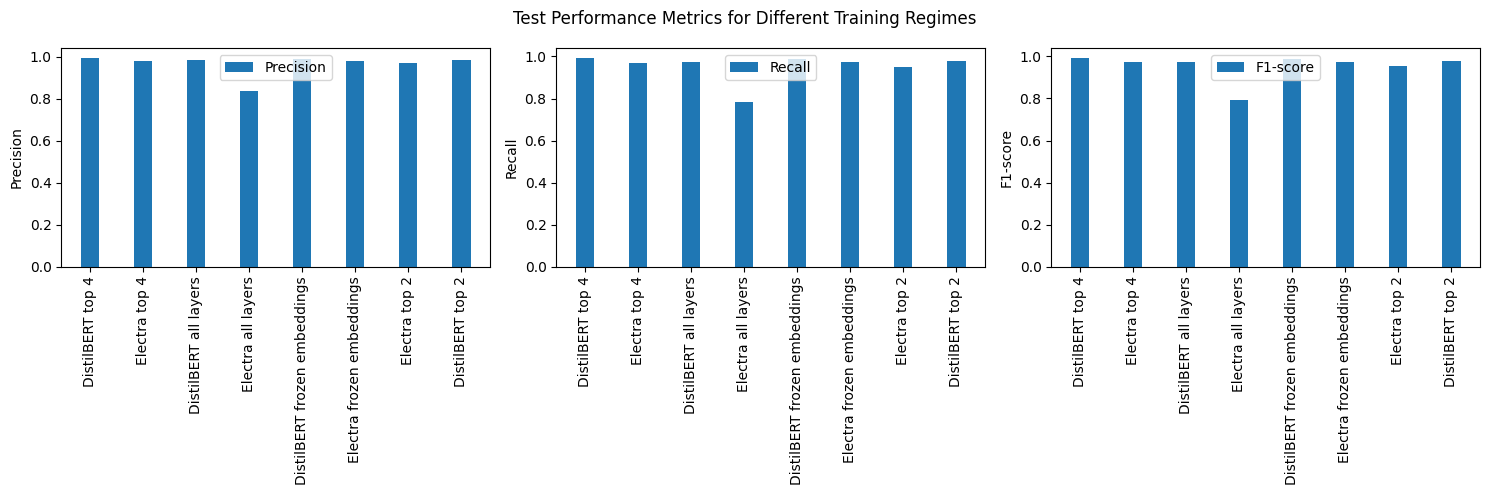

'\n    \\begin{tabular}{|l|c|c|c|}\n    \\hline\n    \\textbf{Model and Training Regime} & \\textbf{Precision} & \\textbf{Recall} & \\textbf{F1 Score} \\\\ \\hline\n    \nDistilBERT top 4 & 0.9924 & 0.9908 & 0.9906 \\\\ \\hline\nElectra top 4 & 0.9816 & 0.9701 & 0.9716 \\\\ \\hline\nDistilBERT all layers & 0.9830 & 0.9740 & 0.9758 \\\\ \\hline\nElectra all layers & 0.8394 & 0.7843 & 0.7913 \\\\ \\hline\nDistilBERT frozen embeddings & 0.9917 & 0.9890 & 0.9887 \\\\ \\hline\nElectra frozen embeddings & 0.9810 & 0.9758 & 0.9754 \\\\ \\hline\nElectra top 2 & 0.9693 & 0.9520 & 0.9557 \\\\ \\hline\nDistilBERT top 2 & 0.9847 & 0.9798 & 0.9795 \\\\ \\hline\n\\end{tabular}'

In [ ]:
options = {}
options['batch_size'] = BATCH_SIZE
options['device'] = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
options['test_data'] = test_data
options['save_path'] = 'models/DistilBERT_top_4_training'
tester = Tester(options)

results.clear()
labels.clear()
results.append(D4_results)
labels.append('DistilBERT top 4')

results.append(E4_results)
labels.append('Electra top 4')

results.append(DA_results)
labels.append('DistilBERT all layers')

results.append(EA_results)
labels.append('Electra all layers')

results.append(df_results)
labels.append('DistilBERT frozen embeddings')

results.append(Ef_results)
labels.append('Electra frozen embeddings')

results.append(E2_results)
labels.append('Electra top 2')

results.append(D2_results)
labels.append('DistilBERT top 2')

tester.plot_final_results(results, labels)
tester.generate_latex_table(results,labels)

#Testing on relevant news articles


In [ ]:
from bs4 import BeautifulSoup
import requests
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report


In [ ]:
#Links to articles
article_dictionary = {}
validation = {}
# negative_interest_rate = r'https://finance.yahoo.com/news/federal-reserve-interest-rate-decision-may-3-155524134.html'
# article_dictionary['interest rate negative'] = negative_interest_rate
# validation ['interest rate negative'] = 'negative'

negative_warren_buffet=r'https://finance.yahoo.com/news/buffett-on-the-regional-bank-crisis-messed-up-incentives-and-poor-communication-211138275.html'
article_dictionary['warren buffet negative'] = negative_warren_buffet
validation ['warren buffet negative'] = 'negative'

carvana_positive = r'https://finance.yahoo.com/news/carvana-stock-surges-as-used-car-dealer-sees-q2-profit-135040050.html'
article_dictionary['carvana positive'] = carvana_positive
validation ['carvana positive'] = 'positive'

banks_neg = r'https://finance.yahoo.com/news/close-190-banks-could-face-163717073.html'
article_dictionary['banks negative'] = banks_neg
validation ['banks negative'] = 'negative'

unforadableBank_negative = r'https://finance.yahoo.com/news/housing-unaffordable-banks-losing-money-014524600.html'
article_dictionary['unafordable bank negative'] = unforadableBank_negative
validation ['unafordable bank negative'] = 'negative'

stockDividend_postive = r'https://finance.yahoo.com/news/6-7-yielding-dividend-etf-213300385.html'
article_dictionary['stock dividend positive'] = stockDividend_postive
validation ['stock dividend positive'] = 'positive'

Mortgage_negative=r'https://finance.yahoo.com/news/housing-market-2023-prices-now-171702377.html'
article_dictionary['mortgage negative'] = Mortgage_negative
validation ['mortgage negative'] = 'negative'

portfolio_neutral=r'https://finance.yahoo.com/video/portfolio-diversification-really-important-millennial-194044581.html'
article_dictionary['potfolio neutral'] = portfolio_neutral
validation ['potfolio neutral'] = 'neutral'

investing_neutral=r'https://www.yahoo.com/news/invest-stocks-beginner-guide-100009203.html'
article_dictionary['investing neutral'] = investing_neutral
validation ['investing neutral'] = 'neutral'

lifestyle_neutral=r'https://www.yahoo.com/lifestyle/there-are-two-types-of-stocks-on-robinhood-181831860.html'
article_dictionary['lifestyle neutral'] = lifestyle_neutral
validation ['lifestyle neutral'] = 'neutral'

economy_postive=r'https://finance.yahoo.com/news/us-economy-has-regained-growth-momentum-in-april-as-recession-fears-swirl-161520510.html'
article_dictionary['economy positive'] = economy_postive
validation ['economy positive'] = 'positive'

tech_positive=r'https://finance.yahoo.com/news/why-tech-stocks-doing-well-150903541.html'
article_dictionary['tech positive'] = tech_positive
validation ['tech positive'] = 'positive'




In [ ]:
def get_article_text(url):
  headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.36'}

  response = requests.get(url, headers=headers)
  if response.status_code == 200:
      soup = BeautifulSoup(response.content, "html.parser")

      # Find the article body
      article_body = soup.find("div", class_="caas-body")

      # Extract all the paragraph texts
      paragraphs = article_body.find_all("p")
      text = " ".join([p.text for p in paragraphs])

  else:
      print(f"Failed to download the webpage. Status code: {response.status_code}")
      text = ""

  return [text]

In [ ]:
class DatasetLoaderSingle(Dataset):

  def __init__(self, data, tokenizer, labels=None):
      self.data = data
      self.tokenizer = tokenizer
      self.labels = labels

  def __len__(self):
      return len(self.data)

  def __getitem__(self, idx):
      text = self.data[idx]
      inputs = self.tokenizer.encode_plus(
          text,
          add_special_tokens=True,
          max_length=512,
          padding='max_length',
          return_tensors='pt',
          truncation=True
      )

      input_ids = inputs['input_ids'][0]
      attention_mask = inputs['attention_mask'][0]

      if self.labels is not None:
          label = self.labels[idx]
          return input_ids, attention_mask, label
      else:
            return input_ids, attention_mask

In [ ]:
class ModelEvaluator():

  def __init__(self, model_path, model_type='distilbert'):
    self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    self.model = AutoModelForSequenceClassification.from_pretrained(model_path)
    self.tokenizer = AutoTokenizer.from_pretrained(model_path)
    self.model.to(self.device)
    self.model_type = model_type

  def analyze_article(self, url):
    # Get the article text
    data = get_article_text(url)

    # Tokenize the text
    unlabeled_dataset = DatasetLoaderSingle(data, self.tokenizer, labels=None)
    self.model.eval()
    predictions = []
    label_dict = {2:'positive', 0:'negative', 1:'neutral'}

    with torch.no_grad():
        for input_ids, attention_mask in tqdm(unlabeled_dataset):
            input_ids = input_ids.to(self.device)
            attention_mask = attention_mask.to(self.device)

            if self.model_type == 'electra':
                input_ids = input_ids.unsqueeze(0)
                attention_mask = attention_mask.unsqueeze(0)

            outputs = self.model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            label = label_dict[preds[0]]
            predictions.append(label)

    return predictions

  def calculate_metrics(self, predictions, labels):
    y_pred = predictions
    y_true = labels
    label_dict = {'positive': 2, 'negative': 0, 'neutral':1}
    y_true = [label_dict[val] for val in y_true]
    y_pred = [label_dict[val] for val in y_pred]

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

    return accuracy, precision, recall, f1


##Top 2 training

In [ ]:
evaluator = ModelEvaluator(model_path='models/DistilBERT_top_2_training/')
d2_preds = {}
for description, link in article_dictionary.items():
  predictions = evaluator.analyze_article(link)
  d2_preds[description] = predictions[0]
  print(f'\n The article {description} is predicted to be {predictions[0]}')

d2_metrics = evaluator.calculate_metrics(list(d2_preds.values()), list(validation.values()))
print(f'Accuracy:{d2_metrics[0]:.4f} Precision:{d2_metrics[1]:.4f} Recall:{d2_metrics[2]:.4f} f1:{d2_metrics[3]:.4f}')

100%|██████████| 1/1 [00:00<00:00, 32.54it/s]



 The article warren buffet negative is predicted to be negative


100%|██████████| 1/1 [00:00<00:00, 36.94it/s]



 The article carvana positive is predicted to be positive


100%|██████████| 1/1 [00:00<00:00, 32.90it/s]



 The article banks negative is predicted to be negative


100%|██████████| 1/1 [00:00<00:00, 35.80it/s]



 The article unafordable bank negative is predicted to be negative


100%|██████████| 1/1 [00:00<00:00, 30.92it/s]



 The article stock dividend positive is predicted to be positive


100%|██████████| 1/1 [00:00<00:00, 31.48it/s]



 The article mortgage negative is predicted to be negative


100%|██████████| 1/1 [00:00<00:00, 28.46it/s]



 The article potfolio neutral is predicted to be negative


100%|██████████| 1/1 [00:00<00:00, 25.02it/s]



 The article investing neutral is predicted to be negative


100%|██████████| 1/1 [00:00<00:00, 30.92it/s]



 The article lifestyle neutral is predicted to be negative


100%|██████████| 1/1 [00:00<00:00, 32.08it/s]



 The article economy positive is predicted to be positive


100%|██████████| 1/1 [00:00<00:00, 30.24it/s]


 The article tech positive is predicted to be positive
Accuracy:0.7273 Precision:0.5714 Recall:0.7273 f1:0.6281


In [ ]:
evaluator = ModelEvaluator(model_path='models/electra-small-discriminator_top_2_training/', model_type='electra')
e2_preds = {}
for description, link in article_dictionary.items():
  predictions = evaluator.analyze_article(link)
  e2_preds[description] = predictions[0]

  print(f'\n The article {description} is predicted to be {predictions[0]}')
e2_metrics = evaluator.calculate_metrics(list(e2_preds.values()), list(validation.values()))
print(f'Accuracy:{e2_metrics[0]:.4f} Precision:{e2_metrics[1]:.4f} Recall:{e2_metrics[2]:.4f} f1:{e2_metrics[3]:.4f}')

100%|██████████| 1/1 [00:00<00:00, 49.25it/s]



 The article warren buffet negative is predicted to be negative


100%|██████████| 1/1 [00:00<00:00, 64.57it/s]



 The article carvana positive is predicted to be positive


100%|██████████| 1/1 [00:00<00:00, 62.62it/s]



 The article banks negative is predicted to be negative


100%|██████████| 1/1 [00:00<00:00, 58.37it/s]



 The article unafordable bank negative is predicted to be negative


100%|██████████| 1/1 [00:00<00:00, 49.84it/s]



 The article stock dividend positive is predicted to be positive


100%|██████████| 1/1 [00:00<00:00, 57.78it/s]



 The article mortgage negative is predicted to be negative


100%|██████████| 1/1 [00:00<00:00, 49.43it/s]



 The article potfolio neutral is predicted to be neutral


100%|██████████| 1/1 [00:00<00:00, 45.59it/s]



 The article investing neutral is predicted to be positive


100%|██████████| 1/1 [00:00<00:00, 54.63it/s]



 The article lifestyle neutral is predicted to be positive


100%|██████████| 1/1 [00:00<00:00, 55.21it/s]



 The article economy positive is predicted to be positive


100%|██████████| 1/1 [00:00<00:00, 41.00it/s]


 The article tech positive is predicted to be negative
Accuracy:0.7273 Precision:0.7818 Recall:0.7273 f1:0.7020


##Top 4 training

In [ ]:
evaluator = ModelEvaluator(model_path='models/electra-small-discriminator_top_4_training/', model_type='electra')
e4_preds = {}

for description, link in article_dictionary.items():
  predictions = evaluator.analyze_article(link)
  e4_preds[description] = predictions[0]

  print(f'\n The article {description} is predicted to be {predictions[0]}')
e4_metrics = evaluator.calculate_metrics(list(e4_preds.values()), list(validation.values()))
print(f'Accuracy:{e4_metrics[0]:.4f} Precision:{e4_metrics[1]:.4f} Recall:{e4_metrics[2]:.4f} f1:{e4_metrics[3]:.4f}')

100%|██████████| 1/1 [00:00<00:00, 51.91it/s]



 The article warren buffet negative is predicted to be neutral


100%|██████████| 1/1 [00:00<00:00, 58.06it/s]



 The article carvana positive is predicted to be negative


100%|██████████| 1/1 [00:00<00:00, 54.87it/s]



 The article banks negative is predicted to be neutral


100%|██████████| 1/1 [00:00<00:00, 59.40it/s]



 The article unafordable bank negative is predicted to be negative


100%|██████████| 1/1 [00:00<00:00, 48.94it/s]



 The article stock dividend positive is predicted to be neutral


100%|██████████| 1/1 [00:00<00:00, 60.20it/s]



 The article mortgage negative is predicted to be negative


100%|██████████| 1/1 [00:00<00:00, 45.81it/s]



 The article potfolio neutral is predicted to be neutral


100%|██████████| 1/1 [00:00<00:00, 45.85it/s]



 The article investing neutral is predicted to be neutral


100%|██████████| 1/1 [00:00<00:00, 53.93it/s]



 The article lifestyle neutral is predicted to be neutral


100%|██████████| 1/1 [00:00<00:00, 53.03it/s]



 The article economy positive is predicted to be positive


100%|██████████| 1/1 [00:00<00:00, 48.82it/s]


 The article tech positive is predicted to be positive
Accuracy:0.6364 Precision:0.7424 Recall:0.6364 f1:0.6320


In [ ]:
evaluator = ModelEvaluator(model_path='models/DistilBERT_top_4_training/')
d4_preds = {}
for description, link in article_dictionary.items():
  predictions = evaluator.analyze_article(link)
  d4_preds[description] = predictions[0]

  print(f'\n The article {description} is predicted to be {predictions[0]}')
d4_metrics = evaluator.calculate_metrics(list(d4_preds.values()), list(validation.values()))
print(f'Accuracy:{d4_metrics[0]:.4f} Precision:{d4_metrics[1]:.4f} Recall:{d4_metrics[2]:.4f} f1:{d4_metrics[3]:.4f}')

100%|██████████| 1/1 [00:00<00:00, 31.97it/s]



 The article warren buffet negative is predicted to be negative


100%|██████████| 1/1 [00:00<00:00, 36.81it/s]



 The article carvana positive is predicted to be positive


100%|██████████| 1/1 [00:00<00:00, 33.91it/s]



 The article banks negative is predicted to be negative


100%|██████████| 1/1 [00:00<00:00, 35.04it/s]



 The article unafordable bank negative is predicted to be negative


100%|██████████| 1/1 [00:00<00:00, 31.13it/s]



 The article stock dividend positive is predicted to be positive


100%|██████████| 1/1 [00:00<00:00, 34.41it/s]



 The article mortgage negative is predicted to be negative


100%|██████████| 1/1 [00:00<00:00, 26.68it/s]



 The article potfolio neutral is predicted to be neutral


100%|██████████| 1/1 [00:00<00:00, 29.94it/s]



 The article investing neutral is predicted to be neutral


100%|██████████| 1/1 [00:00<00:00, 32.32it/s]



 The article lifestyle neutral is predicted to be neutral


100%|██████████| 1/1 [00:00<00:00, 33.97it/s]



 The article economy positive is predicted to be positive


100%|██████████| 1/1 [00:00<00:00, 31.92it/s]


 The article tech positive is predicted to be positive
Accuracy:1.0000 Precision:1.0000 Recall:1.0000 f1:1.0000


##All layers

In [ ]:
evaluator = ModelEvaluator(model_path='models/electra-small-discriminator_all_layers/', model_type='electra')
da_preds = {}
for description, link in article_dictionary.items():
  predictions = evaluator.analyze_article(link)
  da_preds[description] = predictions[0]

  print(f'\n The article {description} is predicted to be {predictions[0]}')
da_metrics = evaluator.calculate_metrics(list(da_preds.values()), list(validation.values()))
print(f'Accuracy:{da_metrics[0]:.4f} Precision:{da_metrics[1]:.4f} Recall:{da_metrics[2]:.4f} f1:{da_metrics[3]:.4f}')

100%|██████████| 1/1 [00:00<00:00, 49.07it/s]



 The article warren buffet negative is predicted to be positive


100%|██████████| 1/1 [00:00<00:00, 52.47it/s]



 The article carvana positive is predicted to be positive


100%|██████████| 1/1 [00:00<00:00, 55.14it/s]



 The article banks negative is predicted to be positive


100%|██████████| 1/1 [00:00<00:00, 61.00it/s]



 The article unafordable bank negative is predicted to be positive


100%|██████████| 1/1 [00:00<00:00, 46.63it/s]



 The article stock dividend positive is predicted to be positive


100%|██████████| 1/1 [00:00<00:00, 56.79it/s]



 The article mortgage negative is predicted to be positive


100%|██████████| 1/1 [00:00<00:00, 46.06it/s]



 The article potfolio neutral is predicted to be neutral


100%|██████████| 1/1 [00:00<00:00, 47.43it/s]



 The article investing neutral is predicted to be positive


100%|██████████| 1/1 [00:00<00:00, 55.25it/s]



 The article lifestyle neutral is predicted to be positive


100%|██████████| 1/1 [00:00<00:00, 55.57it/s]



 The article economy positive is predicted to be positive


100%|██████████| 1/1 [00:00<00:00, 52.78it/s]


 The article tech positive is predicted to be positive
Accuracy:0.4545 Precision:0.4182 Recall:0.4545 f1:0.3442


In [ ]:
evaluator = ModelEvaluator(model_path='models/distilBERT_all_training/')
ea_preds = {}
for description, link in article_dictionary.items():
  predictions = evaluator.analyze_article(link)
  ea_preds[description] = predictions[0]

  print(f'\n The article {description} is predicted to be {predictions[0]}')
ea_metrics = evaluator.calculate_metrics(list(ea_preds.values()), list(validation.values()))
print(f'Accuracy:{ea_metrics[0]:.4f} Precision:{ea_metrics[1]:.4f} Recall:{ea_metrics[2]:.4f} f1:{ea_metrics[3]:.4f}')

100%|██████████| 1/1 [00:00<00:00, 31.36it/s]



 The article warren buffet negative is predicted to be negative


100%|██████████| 1/1 [00:00<00:00, 33.78it/s]



 The article carvana positive is predicted to be positive


100%|██████████| 1/1 [00:00<00:00, 31.10it/s]



 The article banks negative is predicted to be negative


100%|██████████| 1/1 [00:00<00:00, 34.10it/s]



 The article unafordable bank negative is predicted to be negative


100%|██████████| 1/1 [00:00<00:00, 30.82it/s]



 The article stock dividend positive is predicted to be positive


100%|██████████| 1/1 [00:00<00:00, 34.38it/s]



 The article mortgage negative is predicted to be negative


100%|██████████| 1/1 [00:00<00:00, 30.19it/s]



 The article potfolio neutral is predicted to be neutral


100%|██████████| 1/1 [00:00<00:00, 30.01it/s]



 The article investing neutral is predicted to be neutral


100%|██████████| 1/1 [00:00<00:00, 25.45it/s]



 The article lifestyle neutral is predicted to be neutral


100%|██████████| 1/1 [00:00<00:00, 33.92it/s]



 The article economy positive is predicted to be positive


100%|██████████| 1/1 [00:00<00:00, 30.57it/s]


 The article tech positive is predicted to be positive
Accuracy:1.0000 Precision:1.0000 Recall:1.0000 f1:1.0000


#Frozen Embeddings

In [ ]:
evaluator = ModelEvaluator(model_path='models/distilBERT_frozen_embeddings/')
df_preds = {}
for description, link in article_dictionary.items():
  predictions = evaluator.analyze_article(link)
  df_preds[description] = predictions[0]
  print(f'\n The article {description} is predicted to be {predictions[0]}')
df_metrics = evaluator.calculate_metrics(list(df_preds.values()), list(validation.values()))
print(f'Accuracy:{df_metrics[0]:.4f} Precision:{df_metrics[1]:.4f} Recall:{df_metrics[2]:.4f} f1:{df_metrics[3]:.4f}')

100%|██████████| 1/1 [00:00<00:00, 32.96it/s]



 The article warren buffet negative is predicted to be negative


100%|██████████| 1/1 [00:00<00:00, 34.67it/s]



 The article carvana positive is predicted to be positive


100%|██████████| 1/1 [00:00<00:00, 33.14it/s]



 The article banks negative is predicted to be negative


100%|██████████| 1/1 [00:00<00:00, 32.51it/s]



 The article unafordable bank negative is predicted to be negative


100%|██████████| 1/1 [00:00<00:00, 26.41it/s]



 The article stock dividend positive is predicted to be positive


100%|██████████| 1/1 [00:00<00:00, 31.79it/s]



 The article mortgage negative is predicted to be negative


100%|██████████| 1/1 [00:00<00:00, 28.81it/s]



 The article potfolio neutral is predicted to be neutral


100%|██████████| 1/1 [00:00<00:00, 25.50it/s]



 The article investing neutral is predicted to be neutral


100%|██████████| 1/1 [00:00<00:00, 31.97it/s]



 The article lifestyle neutral is predicted to be neutral


100%|██████████| 1/1 [00:00<00:00, 34.18it/s]



 The article economy positive is predicted to be positive


100%|██████████| 1/1 [00:00<00:00, 32.32it/s]


 The article tech positive is predicted to be positive
Accuracy:1.0000 Precision:1.0000 Recall:1.0000 f1:1.0000


In [ ]:
evaluator = ModelEvaluator(model_path='models/electra-small-discriminator_frozen_embeddings/', model_type='electra')
ef_preds = {}

for description, link in article_dictionary.items():
  predictions = evaluator.analyze_article(link)
  ef_preds[description] = predictions[0]

  print(f'\n The article {description} is predicted to be {predictions[0]}')
ef_metrics = evaluator.calculate_metrics(list(ef_preds.values()), list(validation.values()))
print(f'Accuracy:{ef_metrics[0]:.4f} Precision:{ef_metrics[1]:.4f} Recall:{ef_metrics[2]:.4f} f1:{ef_metrics[3]:.4f}')

100%|██████████| 1/1 [00:00<00:00, 53.12it/s]



 The article warren buffet negative is predicted to be negative


100%|██████████| 1/1 [00:00<00:00, 58.92it/s]



 The article carvana positive is predicted to be positive


100%|██████████| 1/1 [00:00<00:00, 57.52it/s]



 The article banks negative is predicted to be positive


100%|██████████| 1/1 [00:00<00:00, 60.07it/s]



 The article unafordable bank negative is predicted to be negative


100%|██████████| 1/1 [00:00<00:00, 47.51it/s]



 The article stock dividend positive is predicted to be neutral


100%|██████████| 1/1 [00:00<00:00, 57.45it/s]



 The article mortgage negative is predicted to be positive


100%|██████████| 1/1 [00:00<00:00, 48.04it/s]



 The article potfolio neutral is predicted to be neutral


100%|██████████| 1/1 [00:00<00:00, 35.83it/s]



 The article investing neutral is predicted to be neutral


100%|██████████| 1/1 [00:00<00:00, 39.50it/s]



 The article lifestyle neutral is predicted to be neutral


100%|██████████| 1/1 [00:00<00:00, 38.10it/s]



 The article economy positive is predicted to be positive


100%|██████████| 1/1 [00:00<00:00, 42.39it/s]


 The article tech positive is predicted to be positive
Accuracy:0.7273 Precision:0.7864 Recall:0.7273 f1:0.7186


##Graph results

In [ ]:
def autolabel(rects):
  for rect in rects:
      height = rect.get_height()
      ax.annotate('{:.2f}'.format(height),
                  xy=(rect.get_x() + rect.get_width() / 2, height),
                  xytext=(0, 3),  # 3 points vertical offset
                  textcoords="offset points",
                  ha='center', va='bottom')

In [ ]:
def generate_latex_table(model_names, accuracies, precisions, recalls, f1_scores):
    latex_table = "\\begin{table}[ht]\n"
    latex_table += "\\centering\n"
    latex_table += "\\begin{tabular}{lcccc}\n"
    latex_table += "\\toprule\n"
    latex_table += "Model & Accuracy & Precision & Recall & F1 Score \\\\\n"
    latex_table += "\\midrule\n"

    for model_name, accuracy, precision, recall, f1_score in zip(model_names, accuracies, precisions, recalls, f1_scores):
        latex_table += f"{model_name} & {accuracy:.2f} & {precision:.2f} & {recall:.2f} & {f1_score:.2f} \\\\\n"

    latex_table += "\\bottomrule\n"
    latex_table += "\\end{tabular}\n"
    latex_table += "\\end{table}\n"

    return latex_table



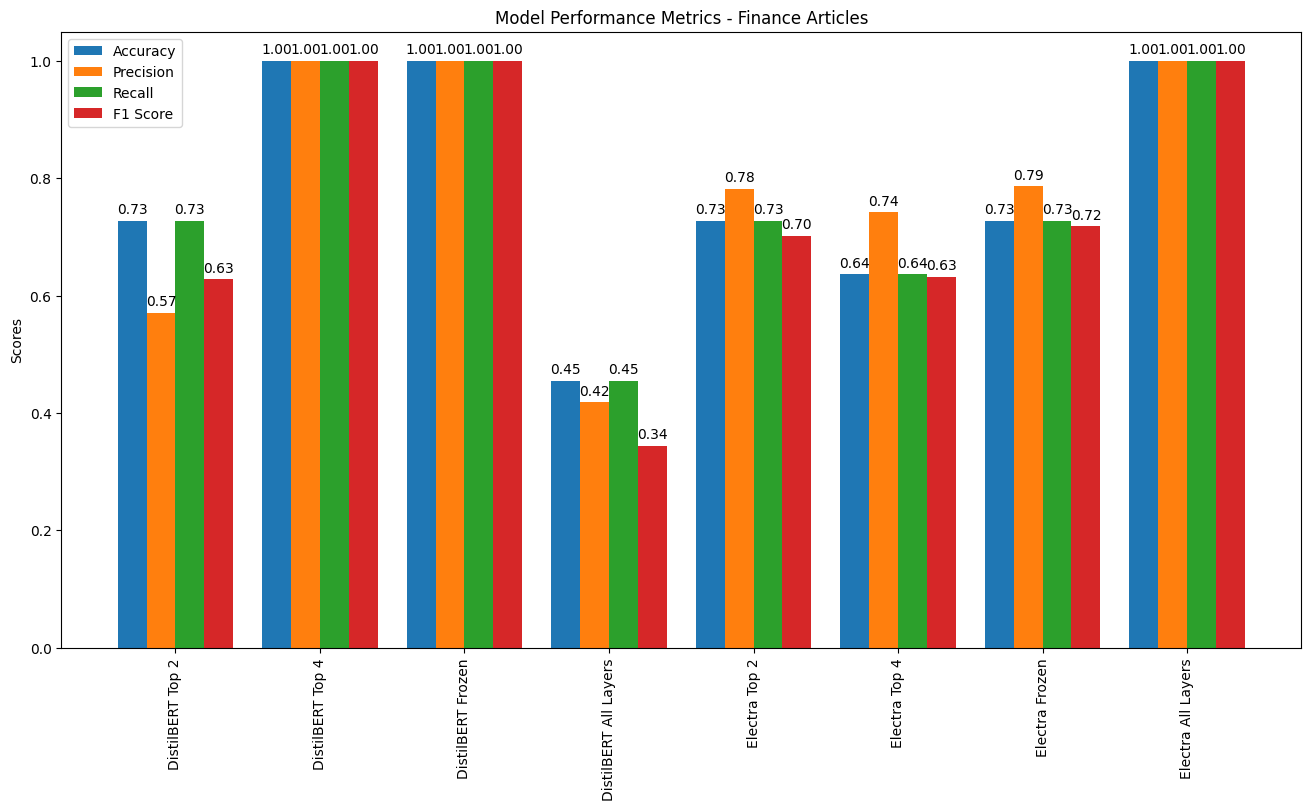

In [ ]:
model_names = ['DistilBERT Top 2', 'DistilBERT Top 4', 'DistilBERT Frozen', 'DistilBERT All Layers', 
               'Electra Top 2', 'Electra Top 4', 'Electra Frozen', 'Electra All Layers']
accuracies = [d2_metrics[0], d4_metrics[0], df_metrics[0], da_metrics[0], 
              e2_metrics[0], e4_metrics[0], ef_metrics[0], ea_metrics[0]]
precisions = [d2_metrics[1], d4_metrics[1], df_metrics[1], da_metrics[1], 
              e2_metrics[1], e4_metrics[1], ef_metrics[1], ea_metrics[1]]
recalls = [d2_metrics[2], d4_metrics[2], df_metrics[2], da_metrics[2], 
           e2_metrics[2], e4_metrics[2], ef_metrics[2], ea_metrics[2]]
f1_scores = [d2_metrics[3], d4_metrics[3], df_metrics[3], da_metrics[3], 
             e2_metrics[3], e4_metrics[3], ef_metrics[3], ea_metrics[3]]

x = np.arange(len(model_names))
width = 0.20

fig, ax = plt.subplots(figsize=(16, 8))
rects1 = ax.bar(x - 1.5 * width, accuracies, width, label='Accuracy')
rects2 = ax.bar(x - 0.5 * width, precisions, width, label='Precision')
rects3 = ax.bar(x + 0.5 * width, recalls, width, label='Recall')
rects4 = ax.bar(x + 1.5 * width, f1_scores, width, label='F1 Score')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)

ax.set_ylabel('Scores')
ax.set_title('Model Performance Metrics - Finance Articles')
ax.set_xticks(x)
ax.set_xticklabels(model_names, rotation=90)  # Set rotation to 90 degrees
ax.legend()

plt.show()

In [ ]:
latex_table = generate_latex_table(model_names, accuracies, precisions, recalls, f1_scores)
print(latex_table)


\begin{table}[ht]
\centering
\begin{tabular}{lcccc}
\toprule
Model & Accuracy & Precision & Recall & F1 Score \\
\midrule
DistilBERT Top 2 & 0.73 & 0.57 & 0.73 & 0.63 \\
DistilBERT Top 4 & 1.00 & 1.00 & 1.00 & 1.00 \\
DistilBERT Frozen & 1.00 & 1.00 & 1.00 & 1.00 \\
DistilBERT All Layers & 0.45 & 0.42 & 0.45 & 0.34 \\
Electra Top 2 & 0.73 & 0.78 & 0.73 & 0.70 \\
Electra Top 4 & 0.64 & 0.74 & 0.64 & 0.63 \\
Electra Frozen & 0.73 & 0.79 & 0.73 & 0.72 \\
Electra All Layers & 1.00 & 1.00 & 1.00 & 1.00 \\
\bottomrule
\end{tabular}
\end{table}



##Retraining on custom dataset

In [ ]:
class CustomDatasetLoader(Dataset):

    def __init__(self, article_dict, validation_dict, tokenizer):
        self.article_dict = article_dict
        self.validation_dict = validation_dict
        self.tokenizer = tokenizer

    def tokenize_data(self):
        print("Processing data..")
        tokens = []
        labels = []
        label_dict = {'positive': 2, 'negative': 0, 'neutral': 1}

        for key, value in tqdm(self.article_dict.items(), total=len(self.article_dict)):
            review = get_article_text(value)
            label = self.validation_dict[key]

            tokenized_review = self.tokenizer.encode_plus(text=review[0],
                                                          add_special_tokens=True,
                                                          max_length=512,
                                                          truncation=True,
                                                          padding='max_length',
                                                          return_tensors='pt')

            input_ids = tokenized_review['input_ids'].squeeze()

            labels.append(label_dict[label])
            tokens.append(input_ids)

        tokens = torch.stack(tokens)
        labels = torch.tensor(labels)
        dataset = TensorDataset(tokens, labels)

        return dataset

    def get_data_loaders(self, batch_size=32, shuffle=True):
        processed_dataset = self.tokenize_data()

        data_loader = DataLoader(
            processed_dataset,
            shuffle=shuffle,
            batch_size=batch_size
        )

        return data_loader


In [ ]:
class CustomTrainer():

  def __init__(self, options):
    self.device = options['device']
    self.train_data = options['train_data']
    self.train_label = options['train_labels']
    self.val_data = options['val_data']
    self.batch_size = options['batch_size']
    self.epochs = options['epochs']
    self.save_path = options['save_path']
    self.training_type = options['training_type']
    self.model_path = options['model_path']
    self.model = AutoModelForSequenceClassification.from_pretrained(self.model_path)
    self.tokenizer = AutoTokenizer.from_pretrained(self.model_path)
    self.model.to(self.device)

  def get_performance_metrics(self, preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    precision = precision_score(labels_flat, pred_flat, average='weighted', zero_division=0)
    recall = recall_score(labels_flat, pred_flat, average='weighted', zero_division=0)
    f1 = f1_score(labels_flat, pred_flat, average='weighted', zero_division=0)
    return precision, recall, f1

  def set_training_parameters(self):

    trainable_layers = []
    if self.training_type in ['top_2_training', 'top_4_training', 'all_training']:
      if self.training_type != 'top_2_training':
        trainable_layers.extend(['transformer.layer.3', 'transformer.layer.2'])
      trainable_layers.extend(['tranformer.layer.5', 'transformer.layer.4'])
    trainable_layers.extend(['pre_classifier', 'classifier'])

    for name, layer in self.model.named_parameters():
      layer.requres_grad = any(trainable_layer in name for trainable_layer in trainable_layers)


  def train(self, data_loader, optimizer):
    self.model.train()
    total_recall = 0
    total_precision = 0
    total_f1 = 0
    total_loss = 0
    for batch_idx, (reviews, labels) in enumerate(tqdm(data_loader)):
      self.model.zero_grad()

      reviews = reviews.to(self.device)
      labels = labels.to(self.device)

      outputs = self.model(reviews, labels=labels)

      optimizer.zero_grad()
      outputs.loss.backward()
      optimizer.step()

      loss, logits = outputs[:2]
      total_loss += loss

      batch_precision, batch_recall, batch_f1 = self.get_performance_metrics(logits.detach().cpu().numpy(), labels.detach().cpu().numpy())
      total_precision += batch_precision
      total_recall += batch_recall
      total_f1 += batch_f1

    precision = total_precision/len(data_loader)
    recall = total_recall/len(data_loader)
    f1 = total_f1/len(data_loader)
    loss = total_loss/len(data_loader)

    return precision, recall, f1, loss

  def eval(self, data_loader):
    self.model.eval()
    total_recall = 0
    total_precision = 0
    total_f1 = 0
    total_loss = 0

    with torch.no_grad():
      for (reviews, labels) in tqdm(data_loader):

        reviews = reviews.to(self.device)
        labels = labels.to(self.device)

        outputs = self.model(reviews, labels=labels)

        loss, logits = outputs[:2]
        total_loss += loss

        precision, recall, f1 = self.get_performance_metrics(logits.detach().cpu().numpy(), labels.detach().cpu().numpy())
        total_precision += precision
        total_recall += recall
        total_f1 += f1

    precision = total_precision/len(data_loader)
    recall = total_recall/len(data_loader)
    f1 = total_f1/len(data_loader)
    loss = total_loss/len(data_loader)

    return precision, recall, f1, loss

  def save_transformer(self):
    self.model.save_pretrained(self.save_path)
    self.tokenizer.save_pretrained(self.save_path)

  def execute(self):
    last_best = 0
    train_dataset = CustomDatasetLoader(self.train_data, self.train_label, self.tokenizer)
    train_data_loader = train_dataset.get_data_loaders(self.batch_size)
    val_dataset = DatasetLoader(self.val_data, self.tokenizer)
    val_data_loader = val_dataset.get_data_loaders(self.batch_size)
    optimizer = torch.optim.AdamW(self.model.parameters(), lr=3e-5, eps=1e-8)
    self.set_training_parameters()
    for epoch_i in range(0, self.epochs):
        train_precision, train_recall, train_f1, train_loss = self.train(train_data_loader, optimizer)
        print(f'Epoch {epoch_i + 1}: train_loss: {train_loss:.4f} train_precision: {train_precision:.4f} train_recall: {train_recall:.4f} train_f1: {train_f1:.4f}')
        val_precision, val_recall, val_f1, val_loss = self.eval(val_data_loader)
        print(f'Epoch {epoch_i + 1}: val_loss: {val_loss:.4f} val_precision: {val_precision:.4f} val_recall: {val_recall:.4f} val_f1: {val_f1:.4f}')

        if val_f1 > last_best:
            print("Saving model..")
            self.save_transformer()
            last_best = val_f1
            print("Model saved.")

##Training on Custom Dataset

In [ ]:
trainer_options = {
    'device': torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
    'train_data': article_dictionary,
    'train_labels':validation,
    'val_data': val_data, 
    'batch_size': 16,
    'epochs': 3,
    'save_path': 'models/article_trained_electra_top_2_training',
    'training_type': 'top_2_training',
    'model_path': 'models/electra-small-discriminator_top_2_training'
}


In [ ]:
trainer = CustomTrainer(trainer_options)
trainer.execute()

Processing data..


100%|██████████| 11/11 [00:06<00:00,  1.70it/s]


Processing data..


100%|██████████| 1/1 [00:03<00:00,  3.24s/it]


Epoch 1: train_loss: 0.7831 train_precision: 0.7879 train_recall: 0.7273 train_f1: 0.7000


100%|██████████| 264/264 [00:26<00:00,  9.89it/s]


Epoch 1: val_loss: 0.3714 val_precision: 0.9075 val_recall: 0.8761 val_f1: 0.8805
Saving model..
Model saved.


100%|██████████| 1/1 [00:00<00:00,  5.11it/s]


Epoch 2: train_loss: 0.6028 train_precision: 0.6091 train_recall: 0.6364 train_f1: 0.6141


100%|██████████| 264/264 [00:26<00:00, 10.08it/s]


Epoch 2: val_loss: 0.3566 val_precision: 0.9051 val_recall: 0.8829 val_f1: 0.8844
Saving model..
Model saved.


100%|██████████| 1/1 [00:00<00:00,  4.88it/s]


Epoch 3: train_loss: 0.4548 train_precision: 0.9318 train_recall: 0.9091 train_f1: 0.9091


100%|██████████| 264/264 [00:25<00:00, 10.34it/s]

Epoch 3: val_loss: 0.3567 val_precision: 0.9064 val_recall: 0.8816 val_f1: 0.8837


In [ ]:
trainer_options = {
    'device': torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
    'train_data': article_dictionary,
    'train_labels':validation,
    'val_data': val_data, 
    'batch_size': 16,
    'epochs': 3,
    'save_path': 'models/article_trained_distilBERT_top_2_training',
    'training_type': 'top_2_training',
    'model_path': 'models/DistilBERT_top_2_training'
}


In [ ]:
trainer = CustomTrainer(trainer_options)
trainer.execute()

Processing data..


100%|██████████| 11/11 [00:05<00:00,  1.85it/s]


Processing data..


100%|██████████| 1/1 [00:03<00:00,  3.12s/it]


Epoch 1: train_loss: 0.4888 train_precision: 0.8788 train_recall: 0.8182 train_f1: 0.7909


100%|██████████| 264/264 [01:03<00:00,  4.15it/s]


Epoch 1: val_loss: 0.2908 val_precision: 0.9213 val_recall: 0.9081 val_f1: 0.9044
Saving model..
Model saved.


100%|██████████| 1/1 [00:00<00:00,  1.97it/s]


Epoch 2: train_loss: 0.2700 train_precision: 1.0000 train_recall: 1.0000 train_f1: 1.0000


100%|██████████| 264/264 [01:07<00:00,  3.90it/s]


Epoch 2: val_loss: 0.2984 val_precision: 0.9146 val_recall: 0.9067 val_f1: 0.9013


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]


Epoch 3: train_loss: 0.1529 train_precision: 1.0000 train_recall: 1.0000 train_f1: 1.0000


100%|██████████| 264/264 [01:12<00:00,  3.66it/s]


Epoch 3: val_loss: 0.2991 val_precision: 0.9167 val_recall: 0.9096 val_f1: 0.9050
Saving model..
Model saved.


In [ ]:
trainer_options = {
    'device': torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
    'train_data': article_dictionary,
    'train_labels':validation,
    'val_data': val_data, 
    'batch_size': 16,
    'epochs': 3,
    'save_path': 'models/article_trained_electra_top_4_training',
    'training_type': 'top_4_training',
    'model_path': 'models/electra-small-discriminator_top_4_training'
}


In [ ]:
trainer = CustomTrainer(trainer_options)
trainer.execute()

Processing data..


100%|██████████| 11/11 [00:06<00:00,  1.70it/s]


Processing data..


100%|██████████| 1/1 [00:00<00:00,  4.01it/s]


Epoch 1: train_loss: 0.7187 train_precision: 0.8442 train_recall: 0.7273 train_f1: 0.7251


100%|██████████| 264/264 [00:24<00:00, 10.96it/s]


Epoch 1: val_loss: 0.3108 val_precision: 0.9190 val_recall: 0.9046 val_f1: 0.9028
Saving model..
Model saved.


100%|██████████| 1/1 [00:00<00:00,  5.15it/s]


Epoch 2: train_loss: 0.7157 train_precision: 0.7879 train_recall: 0.7273 train_f1: 0.7000


100%|██████████| 264/264 [00:24<00:00, 10.70it/s]


Epoch 2: val_loss: 0.3103 val_precision: 0.9217 val_recall: 0.9048 val_f1: 0.9044
Saving model..
Model saved.


100%|██████████| 1/1 [00:00<00:00,  5.31it/s]

Epoch 3: train_loss: 0.6121 train_precision: 0.8788 train_recall: 0.8182 train_f1: 0.8208

100%|██████████| 264/264 [00:24<00:00, 10.72it/s]

Epoch 3: val_loss: 0.3121 val_precision: 0.9191 val_recall: 0.9039 val_f1: 0.9023


In [ ]:
trainer_options = {
    'device': torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
    'train_data': article_dictionary,
    'train_labels':validation,
    'val_data': val_data, 
    'batch_size': 16,
    'epochs': 3,
    'save_path': 'models/article_trained_distilBERT_all_training',
    'training_type': 'all_training',
    'model_path': 'models/distilBERT_all_training'
}

In [ ]:
trainer = CustomTrainer(trainer_options)
trainer.execute()

Processing data..


100%|██████████| 11/11 [00:05<00:00,  2.01it/s]


Processing data..


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]


Epoch 1: train_loss: 0.5077 train_precision: 0.9273 train_recall: 0.9091 train_f1: 0.9051


100%|██████████| 264/264 [01:05<00:00,  4.01it/s]


Epoch 1: val_loss: 0.2872 val_precision: 0.9258 val_recall: 0.9117 val_f1: 0.9120
Saving model..
Model saved.


100%|██████████| 1/1 [00:00<00:00,  1.91it/s]


Epoch 2: train_loss: 0.3048 train_precision: 0.9318 train_recall: 0.9091 train_f1: 0.9091


100%|██████████| 264/264 [01:08<00:00,  3.88it/s]


Epoch 2: val_loss: 0.2926 val_precision: 0.9308 val_recall: 0.9126 val_f1: 0.9140
Saving model..
Model saved.


100%|██████████| 1/1 [00:00<00:00,  1.86it/s]


Epoch 3: train_loss: 0.1040 train_precision: 1.0000 train_recall: 1.0000 train_f1: 1.0000


100%|██████████| 264/264 [01:12<00:00,  3.66it/s]

Epoch 3: val_loss: 0.2999 val_precision: 0.9282 val_recall: 0.9109 val_f1: 0.9126


##New Finance Articles to Test

In [ ]:
#Links to articles
article_dictionary = {}
validation = {}
# negative_interest_rate = r'https://finance.yahoo.com/news/federal-reserve-interest-rate-decision-may-3-155524134.html'
# article_dictionary['interest rate negative'] = negative_interest_rate
# validation ['interest rate negative'] = 'negative'

housing_market_positive=r'https://finance.yahoo.com/news/housing-confidence-jumps-by-largest-amount-in-two-years-183912533.html'
article_dictionary['housing market positive'] = housing_market_positive
validation ['housing market positive'] = 'positive'

stocks_neutral = r'https://finance.yahoo.com/news/stock-market-news-today-live-updates-may-8-115018101.html'
article_dictionary['stocks neutral'] = stocks_neutral
validation ['stocks neutral'] = 'neutral'

tesla_positive = r'https://finance.yahoo.com/news/tesla-stock-jumps-55-on-friday-snaps-longest-weekly-losing-streak-since-2021-201813547.html'
article_dictionary['tesla positive'] = tesla_positive
validation ['tesla positive'] = 'positive'

lyft_negative = r'https://finance.yahoo.com/news/lyft-q1-earnings-143301253.html'
article_dictionary['lyft negative'] = lyft_negative
validation ['lyft negative'] = 'negative'

peloton_negative = r'https://finance.yahoo.com/news/peloton-stock-tanks-on-forecast-for-challenging-fourth-quarter-194437985.html'
article_dictionary['peloton negative'] = peloton_negative
validation ['peloton negative'] = 'negative'

ai_neutral=r'https://finance.yahoo.com/news/ai-is-an-inevitability-but-theres-one-area-it-wont-completely-change-greycrofts-dana-settle-182051256.html'
article_dictionary['ai neutral'] = ai_neutral
validation ['ai neutral'] = 'neutral'

medical_debt_positive=r'https://finance.yahoo.com/news/millions-poised-to-get-a-better-credit-score-after-medical-debt-dropped-from-reports-210927590.html'
article_dictionary['medical debt positive'] = medical_debt_positive
validation ['medical debt positive'] = 'positive'

sp_positive=r'https://finance.yahoo.com/news/stifel-raises-sp-forecast-citing-economic-resilience-164216721.html'
article_dictionary['s&p positive'] = sp_positive
validation ['s&p positive'] = 'positive'

stock_market_negative=r'https://finance.yahoo.com/news/stocks-slump-as-regional-banks-tank-stock-market-news-today-153658149.html'
article_dictionary['stock market negative'] = stock_market_negative
validation ['stock market negative'] = 'negative'

paramaount_negative=r'https://finance.yahoo.com/news/paramount-earnings-first-quarter-2023-may-4-112140604.html'
article_dictionary['paramount negative'] = paramaount_negative
validation ['paramount negative'] = 'negative'

apple_neutral=r'https://finance.yahoo.com/news/apple-isnt-playing-the-ai-hype-game-190726240.html'
article_dictionary['apple neutral'] = apple_neutral
validation ['apple neutral'] = 'neutral'




In [ ]:
evaluator = ModelEvaluator(model_path='models/article_trained_distilBERT_top_2_training/')
d2_preds = {}
for description, link in article_dictionary.items():
  predictions = evaluator.analyze_article(link)
  d2_preds[description] = predictions[0]
  print(f'\n The article {description} is predicted to be {predictions[0]}')

d2_metrics = evaluator.calculate_metrics(list(d2_preds.values()), list(validation.values()))
print(f'Accuracy:{d2_metrics[0]:.4f} Precision:{d2_metrics[1]:.4f} Recall:{d2_metrics[2]:.4f} f1:{d2_metrics[3]:.4f}')

100%|██████████| 1/1 [00:00<00:00, 32.70it/s]



 The article housing market positive is predicted to be positive


100%|██████████| 1/1 [00:00<00:00, 34.80it/s]



 The article stocks neutral is predicted to be positive


100%|██████████| 1/1 [00:00<00:00, 35.41it/s]



 The article tesla positive is predicted to be positive


100%|██████████| 1/1 [00:00<00:00, 35.58it/s]



 The article lyft negative is predicted to be positive


100%|██████████| 1/1 [00:00<00:00, 36.10it/s]



 The article peloton negative is predicted to be negative


100%|██████████| 1/1 [00:00<00:00, 33.71it/s]



 The article ai neutral is predicted to be neutral


100%|██████████| 1/1 [00:00<00:00, 33.50it/s]



 The article medical debt positive is predicted to be positive


100%|██████████| 1/1 [00:00<00:00, 33.99it/s]



 The article s&p positive is predicted to be positive


100%|██████████| 1/1 [00:00<00:00, 31.71it/s]



 The article stock market negative is predicted to be negative


100%|██████████| 1/1 [00:00<00:00, 29.54it/s]



 The article paramount negative is predicted to be positive


100%|██████████| 1/1 [00:00<00:00, 30.57it/s]


 The article apple neutral is predicted to be positive
Accuracy:0.6364 Precision:0.8182 Recall:0.6364 f1:0.6212


In [ ]:
evaluator = ModelEvaluator(model_path='models/article_trained_electra_top_2_training/', model_type='electra')
e2_preds = {}
for description, link in article_dictionary.items():
  predictions = evaluator.analyze_article(link)
  e2_preds[description] = predictions[0]

  print(f'\n The article {description} is predicted to be {predictions[0]}')
e2_metrics = evaluator.calculate_metrics(list(e2_preds.values()), list(validation.values()))
print(f'Accuracy:{e2_metrics[0]:.4f} Precision:{e2_metrics[1]:.4f} Recall:{e2_metrics[2]:.4f} f1:{e2_metrics[3]:.4f}')

100%|██████████| 1/1 [00:00<00:00, 36.18it/s]



 The article housing market positive is predicted to be positive


100%|██████████| 1/1 [00:00<00:00, 29.90it/s]



 The article stocks neutral is predicted to be negative


100%|██████████| 1/1 [00:00<00:00, 32.20it/s]



 The article tesla positive is predicted to be positive


100%|██████████| 1/1 [00:00<00:00, 63.50it/s]



 The article lyft negative is predicted to be negative


100%|██████████| 1/1 [00:00<00:00, 50.45it/s]



 The article peloton negative is predicted to be negative


100%|██████████| 1/1 [00:00<00:00, 51.38it/s]



 The article ai neutral is predicted to be neutral


100%|██████████| 1/1 [00:00<00:00, 46.81it/s]



 The article medical debt positive is predicted to be positive


100%|██████████| 1/1 [00:00<00:00, 57.77it/s]



 The article s&p positive is predicted to be positive


100%|██████████| 1/1 [00:00<00:00, 49.56it/s]



 The article stock market negative is predicted to be negative


100%|██████████| 1/1 [00:00<00:00, 51.47it/s]



 The article paramount negative is predicted to be negative


100%|██████████| 1/1 [00:00<00:00, 55.44it/s]


 The article apple neutral is predicted to be positive
Accuracy:0.8182 Precision:0.8545 Recall:0.8182 f1:0.7828


In [ ]:
evaluator = ModelEvaluator(model_path='models/article_trained_electra_top_4_training/', model_type='electra')
e4_preds = {}
for description, link in article_dictionary.items():
  predictions = evaluator.analyze_article(link)
  e2_preds[description] = predictions[0]

  print(f'\n The article {description} is predicted to be {predictions[0]}')
e4_metrics = evaluator.calculate_metrics(list(e2_preds.values()), list(validation.values()))
print(f'Accuracy:{e4_metrics[0]:.4f} Precision:{e4_metrics[1]:.4f} Recall:{e4_metrics[2]:.4f} f1:{e4_metrics[3]:.4f}')

100%|██████████| 1/1 [00:00<00:00, 53.44it/s]



 The article housing market positive is predicted to be positive


100%|██████████| 1/1 [00:00<00:00, 58.64it/s]



 The article stocks neutral is predicted to be negative


100%|██████████| 1/1 [00:00<00:00, 57.05it/s]



 The article tesla positive is predicted to be positive


100%|██████████| 1/1 [00:00<00:00, 59.56it/s]



 The article lyft negative is predicted to be positive


100%|██████████| 1/1 [00:00<00:00, 56.84it/s]



 The article peloton negative is predicted to be negative


100%|██████████| 1/1 [00:00<00:00, 53.36it/s]



 The article ai neutral is predicted to be neutral


100%|██████████| 1/1 [00:00<00:00, 52.39it/s]



 The article medical debt positive is predicted to be positive


100%|██████████| 1/1 [00:00<00:00, 53.42it/s]



 The article s&p positive is predicted to be positive


100%|██████████| 1/1 [00:00<00:00, 51.13it/s]



 The article stock market negative is predicted to be negative


100%|██████████| 1/1 [00:00<00:00, 52.64it/s]



 The article paramount negative is predicted to be negative


100%|██████████| 1/1 [00:00<00:00, 44.86it/s]


 The article apple neutral is predicted to be neutral
Accuracy:0.8182 Precision:0.8364 Recall:0.8182 f1:0.8141


In [ ]:
evaluator = ModelEvaluator(model_path='models/article_trained_distilBERT_all_training/')
da_preds = {}
for description, link in article_dictionary.items():
  predictions = evaluator.analyze_article(link)
  d2_preds[description] = predictions[0]
  print(f'\n The article {description} is predicted to be {predictions[0]}')

da_metrics = evaluator.calculate_metrics(list(d2_preds.values()), list(validation.values()))
print(f'Accuracy:{da_metrics[0]:.4f} Precision:{da_metrics[1]:.4f} Recall:{da_metrics[2]:.4f} f1:{da_metrics[3]:.4f}')

100%|██████████| 1/1 [00:00<00:00, 32.89it/s]



 The article housing market positive is predicted to be positive


100%|██████████| 1/1 [00:00<00:00, 33.63it/s]



 The article stocks neutral is predicted to be positive


100%|██████████| 1/1 [00:00<00:00, 35.37it/s]



 The article tesla positive is predicted to be positive


100%|██████████| 1/1 [00:00<00:00, 34.00it/s]



 The article lyft negative is predicted to be positive


100%|██████████| 1/1 [00:00<00:00, 33.84it/s]



 The article peloton negative is predicted to be negative


100%|██████████| 1/1 [00:00<00:00, 33.40it/s]



 The article ai neutral is predicted to be neutral


100%|██████████| 1/1 [00:00<00:00, 32.95it/s]



 The article medical debt positive is predicted to be positive


100%|██████████| 1/1 [00:00<00:00, 32.78it/s]



 The article s&p positive is predicted to be positive


100%|██████████| 1/1 [00:00<00:00, 33.06it/s]



 The article stock market negative is predicted to be negative


100%|██████████| 1/1 [00:00<00:00, 31.66it/s]



 The article paramount negative is predicted to be positive


100%|██████████| 1/1 [00:00<00:00, 33.16it/s]


 The article apple neutral is predicted to be positive
Accuracy:0.6364 Precision:0.8182 Recall:0.6364 f1:0.6212


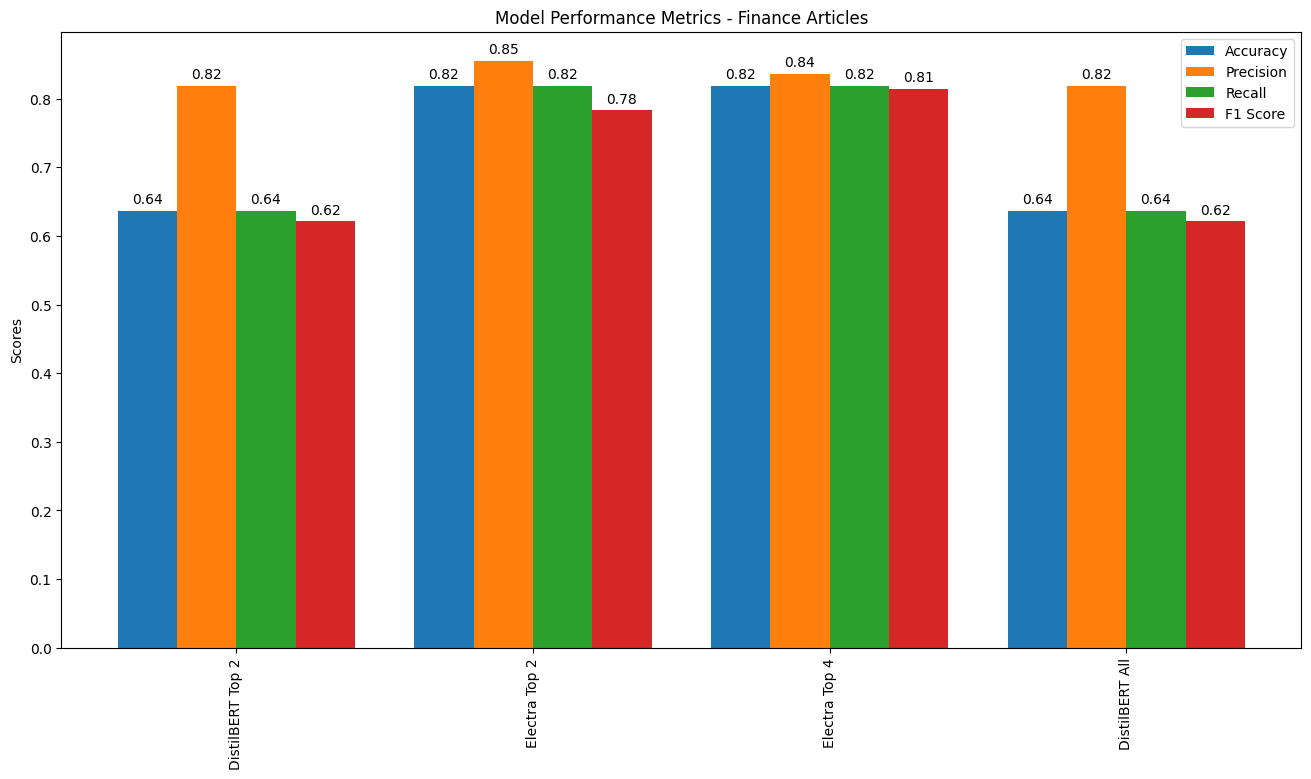

In [ ]:
model_names = ['DistilBERT Top 2', 'Electra Top 2', 'Electra Top 4', 'DistilBERT All']
accuracies = [d2_metrics[0],e2_metrics[0], e4_metrics[0], da_metrics[0]]
precisions = [d2_metrics[1], e2_metrics[1],e4_metrics[1], da_metrics[1]]
recalls = [d2_metrics[2],e2_metrics[2],e4_metrics[2], da_metrics[2]]
f1_scores = [d2_metrics[3],e2_metrics[3 ],e4_metrics[3], da_metrics[3]]

x = np.arange(len(model_names))
width = 0.20

fig, ax = plt.subplots(figsize=(16, 8))
rects1 = ax.bar(x - 1.5 * width, accuracies, width, label='Accuracy')
rects2 = ax.bar(x - 0.5 * width, precisions, width, label='Precision')
rects3 = ax.bar(x + 0.5 * width, recalls, width, label='Recall')
rects4 = ax.bar(x + 1.5 * width, f1_scores, width, label='F1 Score')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)

ax.set_ylabel('Scores')
ax.set_title('Model Performance Metrics - Finance Articles')
ax.set_xticks(x)
ax.set_xticklabels(model_names, rotation=90)  # Set rotation to 90 degrees
ax.legend()

plt.show()

In [ ]:
latex_table = generate_latex_table(model_names, accuracies, precisions, recalls, f1_scores)
print(latex_table)


\begin{table}[ht]
\centering
\begin{tabular}{lcccc}
\toprule
Model & Accuracy & Precision & Recall & F1 Score \\
\midrule
DistilBERT Top 2 & 0.64 & 0.82 & 0.64 & 0.62 \\
Electra Top 2 & 0.82 & 0.85 & 0.82 & 0.78 \\
Electra Top 4 & 0.82 & 0.84 & 0.82 & 0.81 \\
DistilBERT All & 0.64 & 0.82 & 0.64 & 0.62 \\
\bottomrule
\end{tabular}
\end{table}



## ***Acknowledgments***

For this project we reused portions of code from CSE 354 HW Assignment 3, provided to us by Professor Niranjan Balasubramanian, and the CSE 354 graduate TA'S. The Training and Dataloader classes were used and modified to accommodate different aspects of the training and testing. The testing class was also modified to handle our specific test requirements. These changes involved modifications to use the dataset loaded via the dataset library as well as our custom dataset (articles from Yahoo Finance), Tokenizing our custom dataset, handle both the DistilBERT and ELECTRA models, and add logging/graphing to visualize our results.